<a href="https://colab.research.google.com/github/nakatoconstance/MDR2020_2021/blob/main/MDR_2020_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Load the data
from google.colab import files
uploaded = files.upload()
np.random.seed(0)


Saving MUST_MDR_DATA_final_MERGED_final.csv to MUST_MDR_DATA_final_MERGED_final.csv


In [4]:
data = pd.read_csv("MUST_MDR_DATA_final_MERGED_final.csv", encoding='latin-1',low_memory=False)
#data = pd.read_csv("MUST_MDR_DATA_final.csv", encoding='latin-1',low_memory=False)
data.head()

,Identification number,Specimen number,Organism,Country,Laboratory,Origin,Last name,First name,Sex,Date of Birth,...,LNZ_ND30,MEM_ND10,MET_ND5,PIP_ND100,CCV_ND30,NOV_ND5,FOX_ND10,PEF_ND10,NOR_ND5,CAZ_ND30
0,O-0179,NaN,NaN,UGA,DMM,h,KABIKIIRA,FLORENCE,f,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,O-0180,NaN,NaN,UGA,DMM,h,TUMUHIMBISE,DEUS,m,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,O-0181,NaN,NaN,UGA,DMM,h,KYAHANGIRWE,BETETH,f,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,O-0182,NaN,NaN,UGA,DMM,h,LUBEGA,SAMUEL,m,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,O-0170,NaN,NaN,UGA,DMM,h,NAKUNDA,ANNITAH,f,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
import pandas as pd

# Dictionary for standardizing organism names
organism_replacements = {
    'nan': 'Unknown organism',
    'spn': 'Streptococcus pneumoniae',  # Respiratory
    'xxx': 'Unknown organism',
    'eco': 'Escherichia coli',
    'kl-': 'Klebsiella species',
    'sau': 'Staphylococcus aureus',
    'mor': 'Moraxella catarrhalis',  # Respiratory
    'pr-': 'Providencia species',
    'ps-': 'Pseudomonas species',
    'en-': 'Enterobacter species',
    'sgc': 'Serratia species',
    'can': 'Candida species',
    'ent': 'Enterococcus species',
    'str': 'Streptococcus species',
    'sal': 'Salmonella species',
    'ci-': 'Citrobacter species',
    'ac-': 'Acinetobacter species',
    'eae': 'Escherichia coli',  # (Enteroaggregative)
    'con': 'Clostridium species',
    'sta': 'Staphylococcus aureus',
    'sat': 'Sarcina species',
    'kpn': 'Klebsiella pneumoniae',  # Respiratory
    'cdi': 'Clostridium difficile',
    'spy': 'Streptococcus pyogenes',  # Respiratory
    'eag': 'Escherichia coli',  # (Enteropathogenic)
    'afs': 'Aspergillus species',  # Respiratory
    'pae': 'Pseudomonas aeruginosa',  # Respiratory
    'scn': 'Streptococcus mitis',  # Respiratory
    'esc': 'Escherichia coli',  # (Enterotoxigenic)
    'cal': 'Candida albicans',
    'efa': 'Enterococcus faecalis',
    'gm-': 'Gram-negative bacteria',
    'pmi': 'Pseudomonas mallei',  # Zoonotic, rare in humans
    'fun': 'Fungal species',
    'shi': 'Shigella species',
    'prv': 'Providencia vulgaris',
    'cfr': 'Corynebacterium species',
    'afl': 'Aspergillus flavus',  # Respiratory
    'pen': 'Penicillium species',
    'kox': 'Klebsiella oxytoca',  # Respiratory
    'yea': 'Yeast',
    'aba': 'Acinetobacter baumannii',  # Respiratory
    'acr': 'Acinetobacter species',
    'ngo': 'Neisseria gonorrhoeae',
    'ani': 'Anisakis species',
    'mmo': 'Mycobacterium marinum',
    'tn': 'Treponema species',
    'nas': 'Nasal flora',  # Respiratory
    'ecl': 'Escherichia coli',  # (Enterohemorrhagic)
    'gnr': 'Gram-negative rods',
    'sc+': 'Streptococcus agalactiae',
    'kl': 'Klebsiella species',  # Respiratory
    'sgm': 'Streptococcus gallolyticus',
    'koz': 'Kocuria species',
    '157': 'Escherichia coli',  # O157:H7
    'nfr': 'Neisseria meningitidis',
    'cne': 'Citrobacter nepaulensis',
    'cdp': 'Campylobacter species',
    'nor': 'Norovirus',
    'bsa': 'Bacillus subtilis',
    'pvu': 'Proteus vulgaris',  # Corrected from Pseudomonas vulgaris
    'bsl': 'Bacillus cereus',
    'ne-': 'Neisseria species',
    'hhe': 'Haemophilus influenzae',  # Respiratory
    'sma': 'Streptococcus mitis',  # Respiratory
    'oth': 'Other pathogens',
    'xx': 'Unknown organism',
    'afb': 'Acinetobacter species',
    'sai': 'Salmonella infantis',
    'caj': 'Corynebacterium jeikeium',
    'cmv': 'Cytomegalovirus',
    'asp': 'Aspergillus species',  # Respiratory
    'cry': 'Cryptococcus neoformans',
    'ha-': 'Helicobacter species',
    'XXX': 'Unknown organism',
    'cdt': 'Corynebacterium diphtheriae',
    'sep': 'Other pathogens',
    'bl': 'Brucella species',
    'ssa': 'Streptococcus salivarius',  # Respiratory
    'pma': 'Pseudomonas aeruginosa',  # Correct human pathogen
    'kas': 'Klebsiella species',  # Duplicate, but valid
}


# Ensure 'Organism' column exists before processing
if "Organism" in data.columns:
    # Convert to lowercase, strip spaces
    data["Organism"] = data["Organism"].astype(str).str.strip().str.lower()

    # Apply replacements using map()
    data["Organism"] = data["Organism"].map(organism_replacements)

    # Fill NaN values where mapping was unsuccessful
    data["Organism"] = data["Organism"].fillna("Unknown organism")

    print("Organism names standardized successfully.")
else:
    print("Error: 'Organism' column not found in dataset.")

# List of only bacterial species
bacteria_only = [
    "Streptococcus pneumoniae", "Staphylococcus aureus", "Enterococcus species",
    "Streptococcus species", "Streptococcus pyogenes", "Streptococcus mitis",
    "Enterococcus faecalis", "Streptococcus agalactiae", "Streptococcus gallolyticus",
    "Streptococcus salivarius", "Kocuria species", "Bacillus subtilis", "Bacillus cereus",
    "Clostridium species", "Clostridium difficile", "Corynebacterium species",
    "Corynebacterium diphtheriae", "Corynebacterium jeikeium", "Escherichia coli",
    "Klebsiella species", "Klebsiella pneumoniae", "Klebsiella oxytoca",
    "Moraxella catarrhalis", "Providencia species", "Providencia vulgaris",
    "Pseudomonas species", "Pseudomonas aeruginosa", "Pseudomonas mallei",
    "Enterobacter species", "Serratia species", "Salmonella species", "Salmonella infantis",
    "Shigella species", "Citrobacter species", "Citrobacter nepaulensis",
    "Acinetobacter species", "Acinetobacter baumannii", "Treponema species",
    "Neisseria gonorrhoeae", "Neisseria meningitidis", "Neisseria species",
    "Campylobacter species", "Brucella species", "Proteus vulgaris",
    "Helicobacter species", "Haemophilus influenzae"
]

# Filter dataset to keep only bacterial organisms
data = data[data["Organism"].isin(bacteria_only)]

print(f"Filtered dataset contains {len(data)} bacterial records.")

#print unique organisms
print(data['Organism'].unique())
# Get the total number of unique organisms
num_unique_organisms = data['Organism'].nunique()

# Print the total number
print("Total number of unique organisms:", num_unique_organisms)
# Save the filtered dataset
data.to_csv("filtered_bacteria_data.csv", index=False)
print("Filtered dataset saved as 'filtered_bacteria_data.csv'.")
##
specimen_type_replacements = {
    # Urine
    'ur': 'Urine',
    'ur.': 'Urine',
    'urine': 'Urine',
    'msu': 'Urine',
    'ue': 'Urine',
    'uc': 'Urine',#Urine Culture


    # Pus Swab
    'ps': 'Pus Swab',
    'pus swab': 'Pus Swab',

    # HVS (Vaginal Swab)
    'va': 'HVS',
    'hvs': 'HVS',
    'V/S': 'HVS',
    'vaginal swab': 'HVS',

    # Sputum
    'sp': 'Sputum',
    'sputum': 'Sputum',
    'sm': 'Sputum',

    # Stool
    'st': 'Stool',
    'stool': 'Stool',
    'sf': 'Stool',

    # Wound Swab
    'wd': 'Wound Swab',
    'ws': 'Wound Swab',
    'sw': 'Wound Swab',
    'wound swab': 'Wound Swab',

    # Throat Swab
    'th': 'Throat Swab',
    'throat swab': 'Throat Swab',

    # Pleural Fluid
    'pf': 'Pleural Fluid',
    'pleural fluid': 'Pleural Fluid',

    # Ear Swab
    'ea': 'Ear Swab',
    'ear swab': 'Ear Swab',

    # Blood Culture
    'bl': 'Blood Culture',
    'blood': 'Blood Culture',
    'sb': 'Blood Culture',
    'bi': 'Blood Culture',
    'blood culture': 'Blood Culture',

    # Abdominal Fluid
    'ab': 'Abdominal Fluid',

    # Peritoneal Dialysis
    'pd': 'Peritoneal Dialysis',

    # Tracheal Aspirate
    'ta': 'Tracheal Aspirate',
    'tracheal swab': 'Tracheal Aspirate',
    'tracheal': 'Tracheal Aspirate',

    # Fluid (Unspecified)
    'fl': 'Fluid (Unspecified)',

    # Ascitic Tap
    'at': 'Ascitic Tap',

    # CSF (Cerebrospinal Fluid)
    'cs': 'CSF',
    'csf': 'CSF',

    # Retroperitoneal Fluid
    'rp': 'Retroperitoneal Fluid',

    # Bone Biopsy
    'bo': 'Bone Biopsy',

    # Seminal Vesicle Fluid
    'sv': 'Seminal Vesicle Fluid',

    # Hepatic Fluid
    'hp': 'Hepatic Fluid',

    # Naso pharyngeal swab
    'no': 'Naso pharyngeal swab',

    # Joint Aspirate
    'ga': 'Joint Aspirate',
    'kf': 'Joint Aspirate',
    'knee': 'Joint Aspirate',
    'jf': 'Joint Aspirate',
    'kn': 'Joint Aspirate',

    # Small Intestine Fluid
    'si': 'Small Intestine Fluid',

    # Penile Fistula Sample
    'penile pestula': 'Penile Fistula Sample',

    # Cervical Swab
    'cx': 'Cervical Swab',
    'cervical swab': 'Cervical Swab',

    # Eye Swab
    'ey': 'Eye Swab',
    'eye swab': 'Eye Swab',

    # External Otitis Swab
    'eo': 'External Otitis Swab',
    'external otitis swab': 'External Otitis Swab',

    # Ascitic Fluid
    'ascitic fluid': 'Ascitic Fluid',
    'ascitic fluid/tap': 'Ascitic Fluid',

    # Uterine Tissue
    'ut': 'Uterine Tissue',

    # Endometrial Tissue
    'end': 'Endometrial Tissue',

    # Ultrasound-Guided Sample
    'us': 'Ultrasound-Guided Sample',
    'u/s': 'Ultrasound-Guided Sample',

    # Tissue Sample
    'ti': 'Tissue Sample',

    # Biopsy Tissue
    'bt': 'Biopsy Tissue',

    # Post-Mortem Sample
    'pm': 'Post-Mortem Sample',

    # Myocardial Infarct Tissue
    'mi': 'Myocardial Infarct Tissue',

    # Synovial Aspirate
    'sa': 'Synovial Aspirate',

    # Debridement Sample
    'de': 'Debridement Sample',

    # Lymph Node Biopsy
    'lx': 'Lymph Node Biopsy',

    # Nasogastric Tube Aspirate
    'ng tube': 'Nasogastric Tube Aspirate',

    # Catheter Residue
    'cr': 'Catheter Residue',

    # Sputum (Another form)
    'sc': 'Sputum',

    # Tracheostomy Sample
    'trasectomy': 'Tracheostomy Sample',

    # Endotracheal Tube Sample
    'ett': 'Endotracheal Tube Sample',

    # Slide Sample
    'slide s': 'Slide Sample',

    # Lymphatic Sample
    'li': 'Lymphatic Sample',

    # Nasal Lavage
    'nl': 'Nasal Lavage',

    # Foot Tissue
    'ft': 'Foot Tissue',

    # Pericardial Effusion Fluid
    'pe': 'Pericardial Effusion Fluid',

    # Ulcer Sample
    'ul': 'Ulcer Sample',

    # Testicular Fluid
    'te': 'Testicular Fluid',

    # Genital Sample
    'gn': 'Genital Sample',

    # Otic Sample
    'ot': 'Otic Sample',

    # Dialysis Fluid
    'di': 'Dialysis Fluid',

    # Ovarian Fluid
    'ov': 'Ovarian Fluid',

    # Endocervical Sample
    'ec': 'Endocervical Sample',

    # Peritoneal Tap
    'pt': 'Peritoneal Tap',

    # Endotracheal Tube Placement Sample
    'ettp': 'Endotracheal Tube Sample',

    # Cervical Culture
    'cc': 'Cervical Culture',

    # Endocervical Swab
    'ecs': 'Endocervical Swab',

    # Handling NaN values (if necessary)
    'nan': 'Unknown',

    # ** Additional Two-Character Entries **
    # Blood Culture
    'bn': 'Blood Culture',  # Example assumption: bn could represent Blood Culture

    'cy': 'Cervical Swab',  # Example assumption: cy could represent Cervical Swab
    'ca': 'Catheter Aspirate',  # Example assumption: ca could represent Cervical Swab
    'ch':  'Genital Swab ',  # Example assumption: ch could represent Cervical Swab

    # Skin Swab (if applicable)
    'sk': 'Skin Swab',  # Example assumption: sk could represent Skin Swab

    # Pus Swab
    'pg': 'Pus Swab',  # Example assumption: pg could represent Pus Swab

    # Synovial Aspirate
    'fn': 'Synovial Aspirate',  # Example assumption: fn could represent Synovial Aspirate

    # Bone Biopsy
    'bm': 'Bone Biopsy',  # Example assumption: bm could represent Bone Biopsy

    # Retroperitoneal Fluid
    're': 'Retroperitoneal Fluid',  # Example assumption: re could represent Retroperitoneal Fluid

    # Myocardial Infarct Tissue
    'mo': 'Myocardial Infarct Tissue',  # Example assumption: mo could represent Myocardial Infarct Tissue

    # Hepatic Fluid
    'ha': 'Hepatic Fluid',  # Example assumption: ha could represent Hepatic Fluid

    # Biopsy Tissue
    'bx': 'Biopsy Tissue',  # Example assumption: bx could represent Biopsy Tissue

    # Blood Culture
    'bld': 'Blood Culture',  # Example assumption: bld could represent Blood Culture

    # Endocervical Sample
    'eh': 'Endocervical Sample',  # Example assumption: eh could represent Endocervical Sample

    # Blood Culture
    'bs': 'Blood Culture',  # Example assumption: bs could represent Blood Culture

    # Tracheostomy Sample
    'tr': 'Tracheostomy Sample',  # Example assumption: tr could represent Tracheostomy Sample

    # Ultrasound-Guided Sample
    'um': 'Ultrasound-Guided Sample',  # Example assumption: um could represent Ultrasound-Guided Sample

    # Plasma Sample
    'pl': 'Plasma Sample',  # Example assumption: pl could represent Plasma Sample

    # Pus Swab
    'pu': 'Pus Swab',  # Example assumption: pu could represent Pus Swab

    # Endotracheal Tube Tip Sample
    'ett tip': 'Endotracheal Tube Sample',  # Example assumption: ett tip could represent Endotracheal Tube Tip Sample
    # Nasal Lavage
    'la': 'Nasal Lavage',  # Correct handling for 'la'
    # Bronchial Wash (Bronchial Sample)
    'br': 'Bronchial Wash',  # Correct handling for 'br'
    # Lymphatic Sample
    'li': 'Lymphatic Sample'  # Example assumption: li could represent Lymphatic Sample
}

# Applying the replacements
data['Specimen type'] = data['Specimen type'].replace(specimen_type_replacements)





Organism names standardized successfully.
Filtered dataset contains 9308 bacterial records.
['Streptococcus pneumoniae' 'Escherichia coli' 'Klebsiella species'
 'Staphylococcus aureus' 'Moraxella catarrhalis' 'Providencia species'
 'Pseudomonas species' 'Enterobacter species' 'Serratia species'
 'Enterococcus species' 'Streptococcus species' 'Salmonella species'
 'Citrobacter species' 'Acinetobacter species' 'Clostridium species'
 'Klebsiella pneumoniae' 'Clostridium difficile' 'Streptococcus pyogenes'
 'Pseudomonas aeruginosa' 'Streptococcus mitis' 'Enterococcus faecalis'
 'Pseudomonas mallei' 'Shigella species' 'Providencia vulgaris'
 'Corynebacterium species' 'Klebsiella oxytoca' 'Acinetobacter baumannii'
 'Neisseria gonorrhoeae' 'Treponema species' 'Streptococcus agalactiae'
 'Streptococcus gallolyticus' 'Kocuria species' 'Neisseria meningitidis'
 'Citrobacter nepaulensis' 'Campylobacter species' 'Bacillus subtilis'
 'Proteus vulgaris' 'Bacillus cereus' 'Neisseria species'
 'Haemop

In [6]:
#percentage of unknown organisms
print(data['Organism'].value_counts(normalize=True) * 100)

Organism
Staphylococcus aureus          43.672110
Klebsiella species             15.030082
Escherichia coli               10.217018
Streptococcus pneumoniae        7.466695
Klebsiella pneumoniae           5.081650
Salmonella species              4.941985
Streptococcus mitis             2.836270
Citrobacter species             1.353674
Pseudomonas species             1.235496
Streptococcus species           1.160292
Enterobacter species            1.052858
Providencia species             0.966910
Pseudomonas aeruginosa          0.870219
Acinetobacter species           0.859476
Enterococcus species            0.580146
Neisseria gonorrhoeae           0.429738
Klebsiella oxytoca              0.386764
Pseudomonas mallei              0.376021
Corynebacterium species         0.214869
Enterococcus faecalis           0.161152
Clostridium species             0.128921
Streptococcus pyogenes          0.128921
Citrobacter nepaulensis         0.128921
Providencia vulgaris            0.118178
Proteus

In [7]:
print(data.columns)

Index(['Identification number', 'Specimen number', 'Organism', 'Country',
       'Laboratory', 'Origin', 'Last name', 'First name', 'Sex',
       'Date of Birth', 'Age', 'Age category', 'Location', 'Institution',
       'Department', 'Location type', 'Date of admission', 'Specimen date',
       'Specimen type', 'Specimen type (Numeric)', 'Reason', 'Isolate number',
       'Organism type', 'Serotype', 'Date of data entry',
       'Hospitalised for more than 48hrs at specimen collection time',
       'Patient transferred from another facility?',
       'Prior antibiotic therapy', 'AMX_ND25', 'AMC_ND20', 'AMK_ND30',
       'AMP_ND10', 'AZM_ND15', 'FEP_ND30', 'BAC_ND10', 'CRO_ND30', 'CXM_ND30',
       'CIP_ND5', 'OXA_ND1', 'CHL_ND30', 'CZO_ND30', 'CLI_ND2', 'GEN_ND10',
       'GEH_ND120', 'ERY_ND15', 'TCY_ND30', 'RIF_ND5', 'SAM_ND10', 'OFX_ND5',
       'SXT_ND12', 'TOB_ND10', 'OPT_ND5', 'MFX_ND5', 'VAN_ND30', 'PEN_ND10',
       'NAL_ND30', 'IPM_ND10', 'CAC_ND30', 'LVX_ND5', 'NIT_ND300', 'C

In [8]:
print(data['Organism'].unique())

['Streptococcus pneumoniae' 'Escherichia coli' 'Klebsiella species'
 'Staphylococcus aureus' 'Moraxella catarrhalis' 'Providencia species'
 'Pseudomonas species' 'Enterobacter species' 'Serratia species'
 'Enterococcus species' 'Streptococcus species' 'Salmonella species'
 'Citrobacter species' 'Acinetobacter species' 'Clostridium species'
 'Klebsiella pneumoniae' 'Clostridium difficile' 'Streptococcus pyogenes'
 'Pseudomonas aeruginosa' 'Streptococcus mitis' 'Enterococcus faecalis'
 'Pseudomonas mallei' 'Shigella species' 'Providencia vulgaris'
 'Corynebacterium species' 'Klebsiella oxytoca' 'Acinetobacter baumannii'
 'Neisseria gonorrhoeae' 'Treponema species' 'Streptococcus agalactiae'
 'Streptococcus gallolyticus' 'Kocuria species' 'Neisseria meningitidis'
 'Citrobacter nepaulensis' 'Campylobacter species' 'Bacillus subtilis'
 'Proteus vulgaris' 'Bacillus cereus' 'Neisseria species'
 'Haemophilus influenzae' 'Salmonella infantis' 'Corynebacterium jeikeium'
 'Helicobacter species' '

In [9]:
#print number for each organism
print(data['Organism'].value_counts())

Organism
Staphylococcus aureus          4065
Klebsiella species             1399
Escherichia coli                951
Streptococcus pneumoniae        695
Klebsiella pneumoniae           473
Salmonella species              460
Streptococcus mitis             264
Citrobacter species             126
Pseudomonas species             115
Streptococcus species           108
Enterobacter species             98
Providencia species              90
Pseudomonas aeruginosa           81
Acinetobacter species            80
Enterococcus species             54
Neisseria gonorrhoeae            40
Klebsiella oxytoca               36
Pseudomonas mallei               35
Corynebacterium species          20
Enterococcus faecalis            15
Clostridium species              12
Streptococcus pyogenes           12
Citrobacter nepaulensis          12
Providencia vulgaris             11
Proteus vulgaris                 11
Shigella species                  7
Acinetobacter baumannii           5
Moraxella catarrhal

In [10]:
#print unique specimen types
print(data['Specimen type'].unique())

['Throat Swab' 'Sputum' 'Wound Swab' 'Urine' 'HVS' 'Pus Swab'
 'Abdominal Fluid' 'Ear Swab' 'Blood Culture' 'Tracheal Aspirate' nan
 'Fluid (Unspecified)' 'Pleural Fluid' 'Naso pharyngeal swab' 'Stool'
 'CSF' 'Small Intestine Fluid' 'Ascitic Tap' 'Cervical Swab'
 'Catheter Aspirate' 'Genital Swab ' 'Eye Swab' 'as' 'Uterine Tissue'
 'Tissue Sample' 'Biopsy Tissue' 'Post-Mortem Sample'
 'Myocardial Infarct Tissue' 'External Otitis Swab' 'Synovial Aspirate'
 'Joint Aspirate' 'Bone Biopsy' 'Retroperitoneal Fluid'
 'Lymph Node Biopsy' 'Peritoneal Tap' 'Nasogastric Tube Aspirate'
 'Seminal Vesicle Fluid' 'Skin Swab' 'Endocervical Sample'
 'Ultrasound-Guided Sample' 'Bronchial Wash' 'Tracheostomy Sample'
 'Pericardial Effusion Fluid' 'Nasal Lavage' 'Genital Sample'
 'Testicular Fluid' 'Endotracheal Tube Sample' 'Otic Sample'
 'Ovarian Fluid' 'Slide Sample' 'Cervical Culture' 'gl' 'ur/sb' 'ur/va'
 'va/ur']


In [11]:
#print unique organism type
print(data['Organism type'].unique())



['+' '-' 'o' 'f' nan]


In [12]:
# Define the column name replacements
column_name_mapping = {

    'AMX_ND25': 'Amoxicillin',
    'AMC_ND20': 'Amoxicillin/Clavulanic Acid',
    'AMK_ND30': 'Amikacin',
    'AMP_ND10': 'Ampicillin',
    'AZM_ND15': 'Azithromycin',
    'FEP_ND30': 'Cefepime',
    'BAC_ND10': 'Bacitracin',
    'CRO_ND30': 'Ceftriaxone',
    'CXM_ND30': 'Cefuroxime',
    'CIP_ND5': 'Ciprofloxacin',
    'OXA_ND1': 'Oxacillin',
    'CHL_ND30': 'Chloramphenicol',
    'CZO_ND30': 'Cefazolin',
    'CLI_ND2': 'Clindamycin',
    'GEN_ND10': 'Gentamicin',
    'GEH_ND120': 'Gentaheptose',
    'ERY_ND15': 'Erythromycin',
    'TCY_ND30': 'Tetracycline',
    'RIF_ND5': 'Rifampicin',
    'SAM_ND10': 'Ampicillin/Sulbactam',
    'OFX_ND5': 'Ofloxacin',
    'SXT_ND12': 'Sulfamethoxazole',  # corrected spelling
    'TOB_ND10': 'Tobramycin',
    'OPT_ND5': 'Optochin',
    'MFX_ND5': 'Moxifloxacin',
    'VAN_ND30': 'Vancomycin',
    'PEN_ND10': 'Penicillin',
    'NAL_ND30': 'Nalidixic Acid',
    'IPM_ND10': 'Imipenem',
    'CAC_ND30': 'Cefaclor',
    'CAZ_ND30': 'Ceftazidime',
    'LVX_ND5': 'Levofloxacin',
    'NIT_ND300': 'Nitrofurantoin',
    'CTC_ND30': 'Chlortetracycline',
    'CTX_ND30': 'Cefotaxime',
    'ATM_ND30': 'Aztreonam',
    'AZL_ND75': 'Azlocillin',
    'CFM_ND5': 'Cefixime',
    'FOX_ND30': 'Cefoxitin 30 mg',  # made unique
    'FOX_ND10': 'Cefoxitin 10 mg',  # made unique
    'DOX_ND30': 'Doxycycline',
    'LNZ_ND30': 'Linezolid',
    'MEM_ND10': 'Meropenem',
    'MET_ND5': 'Metronidazole',
    'PIP_ND100': 'Piperacillin',
    'CCV_ND30': 'Cefovecin',
    'NOV_ND5': 'Novobiocin',
    'PEF_ND10': 'Pefloxacin',
    'NOR_ND5': 'Norfloxacin'
}

# Get existing columns in the DataFrame
existing_columns = data.columns

# Filter the mapping to only include existing columns
filtered_mapping = {k: v for k, v in column_name_mapping.items() if k in existing_columns}

# Replace the column names
data = data.rename(columns=filtered_mapping)

In [14]:
#droping missing organisms
data = data.dropna(subset=['Organism'])

In [15]:
#check total number of records
print(len(data))

9308


In [16]:
# Check the unique values in the 'Sex' column
print(data['Sex'].unique())

# Check the data type of the 'Sex' column
print(data['Sex'].dtype)
#count columns with nan or -
nan_count = data['Sex'].isna().sum()
print("Number of NaN values in 'Sex' column:", nan_count)


['m' 'f' nan '-']
object
Number of NaN values in 'Sex' column: 751


In [17]:
#droping sex with  '-'
data = data[data['Sex'] != '-']
#droping unknown sex
data=data.dropna(subset=['Sex'])


In [18]:
# Select columns 8 to 31
columns_to_encode = data.columns[28:78]

# One-hot encode, handling only I, R, and S
data_encoded = pd.DataFrame()
for col in columns_to_encode:
    temp_df = pd.get_dummies(data[col], prefix=col)  # Encode all values
    value_mapping = {'I': col + '_I', 'R': col + '_R', 'S': col + '_S'}
    desired_columns = [value_mapping[val] for val in value_mapping if value_mapping[val] in temp_df.columns]
    if desired_columns:
        temp_df = temp_df[desired_columns]
        data_encoded = pd.concat([data_encoded, temp_df], axis=1)

# Concatenate encoded columns with original DataFrame
data = pd.concat([data, data_encoded], axis=1)

# Change datatype of encoded columns to int and impute missing values
encoded_column_names = data_encoded.columns.tolist()
data[encoded_column_names] = data[encoded_column_names].fillna(0).astype(int)  # Fill NaN first

print(encoded_column_names)  # Display the encoded column names

['Amoxicillin_I', 'Amoxicillin_R', 'Amoxicillin_S', 'Amoxicillin/Clavulanic Acid_I', 'Amoxicillin/Clavulanic Acid_R', 'Amoxicillin/Clavulanic Acid_S', 'Amikacin_I', 'Amikacin_R', 'Amikacin_S', 'Ampicillin_I', 'Ampicillin_R', 'Ampicillin_S', 'Azithromycin_I', 'Azithromycin_R', 'Azithromycin_S', 'Cefepime_I', 'Cefepime_R', 'Cefepime_S', 'Bacitracin_S', 'Ceftriaxone_I', 'Ceftriaxone_R', 'Ceftriaxone_S', 'Cefuroxime_I', 'Cefuroxime_R', 'Cefuroxime_S', 'Ciprofloxacin_I', 'Ciprofloxacin_R', 'Ciprofloxacin_S', 'Oxacillin_I', 'Oxacillin_R', 'Oxacillin_S', 'Chloramphenicol_I', 'Chloramphenicol_R', 'Chloramphenicol_S', 'Cefazolin_I', 'Cefazolin_R', 'Cefazolin_S', 'Clindamycin_I', 'Clindamycin_R', 'Clindamycin_S', 'Gentamicin_I', 'Gentamicin_R', 'Gentamicin_S', 'Gentaheptose_I', 'Gentaheptose_R', 'Gentaheptose_S', 'Erythromycin_I', 'Erythromycin_R', 'Erythromycin_S', 'Tetracycline_I', 'Tetracycline_R', 'Tetracycline_S', 'Rifampicin_R', 'Rifampicin_S', 'Ofloxacin_R', 'Ofloxacin_S', 'Sulfamethoxazo

In [19]:
#droping original columns
# Assuming 'columns_to_encode' contains the names of original columns you encoded:
data = data.drop(columns=columns_to_encode)

In [20]:
#checking missing specimen date
missing_data = data['Specimen date'].isnull().sum()
print(missing_data)

745


In [21]:
data['Specimen date'] = pd.to_datetime(data['Specimen date'], dayfirst=True)
data['Specimen date'] = data['Specimen date'].interpolate(method='linear')  # Example

In [22]:
# Check for NaN values in encoded columns
nan_values = data[encoded_column_names].isna().sum()
print(nan_values)

Amoxicillin_I                    0
Amoxicillin_R                    0
Amoxicillin_S                    0
Amoxicillin/Clavulanic Acid_I    0
Amoxicillin/Clavulanic Acid_R    0
                                ..
Pefloxacin_S                     0
Norfloxacin_R                    0
Norfloxacin_S                    0
Ceftazidime_R                    0
Ceftazidime_S                    0
Length: 130, dtype: int64


In [23]:
print(data[encoded_column_names].head(10))  # Check the first 10 rows of encoded columns
#print(data.info())  # Get summary information about the DataFrame

    Amoxicillin_I  Amoxicillin_R  Amoxicillin_S  \
24              0              0              0   
26              0              0              0   
27              0              0              0   
37              0              0              0   
40              0              0              0   
43              0              0              0   
44              0              0              0   
54              0              0              0   
58              0              0              0   
59              0              0              0   

    Amoxicillin/Clavulanic Acid_I  Amoxicillin/Clavulanic Acid_R  \
24                              0                              1   
26                              0                              0   
27                              0                              0   
37                              0                              1   
40                              0                              1   
43                            

In [24]:
data.columns

Index(['Identification number', 'Specimen number', 'Organism', 'Country',
       'Laboratory', 'Origin', 'Last name', 'First name', 'Sex',
       'Date of Birth',
       ...
       'Novobiocin_R', 'Novobiocin_S', 'Cefoxitin 10 mg_R',
       'Cefoxitin 10 mg_S', 'Pefloxacin_R', 'Pefloxacin_S', 'Norfloxacin_R',
       'Norfloxacin_S', 'Ceftazidime_R', 'Ceftazidime_S'],
      dtype='object', length=158)

In [25]:
#check empty age columns
missing_data = data['Age'].isnull().sum()
print(missing_data)
#show unique age
print(data['Age'].unique())

638
['9' '50' '36' '20' '69' '26' '40' '60' '42' '92' '72' '81' '35' '38' '12'
 '13' '21' '27' '29' '6' '30' '14' '58' '95' '5' '70' '64' '55' '68' '56'
 '45' '73' '51' '24' '25' '6w' '18' '28' '39' '85' '76' '49' '43' '23'
 '37' '34' '75' '46' '15' nan '44' '47' '59' '17' '48' '32' '33' '19' '1'
 '89' '80' '66' '1m' '78' '53' '9d' '2' '74' '71' '93' '22' '54' '65' '7'
 '52' '3' '61' '11' '31' '10' '83' '57' '67' '79' '4m' '62' '3m' '8' '98'
 '87' '41' '16' '4d' '82' '13w' '8m' '4' '25w' '63' '88' '90' '84' '13d'
 '1w' '2w' '2d' '77' '4w' '8d' '21m' '15d' '23d' '3w' '10w' '18m' '1d'
 '86' '13m' 'ad' '11m' '9m' '6m' '7d' '5m' '26d' '91' '3d' '10m' '20d'
 '6d' '10d' '21d' '16d' '7m' '5d' '2m' '100' '35d' '94' '19d' '28d' '18d'
 '12w' '7w' '96' 'f' '97' '12m' '12d' '17d' 'n' '29d' '11d' '101' '24d'
 '22d' '105' '1.5' 'au']


In [26]:
import pandas as pd
import re

def standardize_age_to_years(age_str):
    """Standardizes age data and converts it to years.

    Args:
        age_str: The age string to standardize.

    Returns:
        The standardized age in years as a float, rounded to 1 decimal place, or NaN if the value is non-numeric.
    """

    try:
        # Ensure age_str is a string
        age_str = str(age_str)  # Convert to string if necessary

        # Check for numeric format
        if re.match(r"^\d+$", age_str):
            return float(age_str)  # Already in years

        # Check for week, month, or day suffixes
        elif age_str.endswith('w'):  # Weeks
            return round(int(age_str[:-1]) / 52.1429, 1)
        elif age_str.endswith('m'):  # Months
            return round(int(age_str[:-1]) / 12, 1)
        elif age_str.endswith('d'):  # Days
            return round(int(age_str[:-1]) / 365.25, 1)

    except ValueError:
        # Handle non-numeric values
        return pd.NA

# Assuming your DataFrame is named 'data' and has an 'Age' column
data['Age'] = data['Age'].apply(standardize_age_to_years)

# Display the standardized data
print(data)
#print standardised age
#print(data['Age'].unique())
#i want to delete None <NAN>
#data = data.dropna(subset=['Age'])

      Identification number Specimen number                  Organism Country  \
24                   O-0150             NaN  Streptococcus pneumoniae     UGA   
26                   O-0151             NaN  Streptococcus pneumoniae     UGA   
27                   O-0152             NaN  Streptococcus pneumoniae     UGA   
37                   O-0142             NaN          Escherichia coli     UGA   
40                   O-0144             NaN          Escherichia coli     UGA   
...                     ...             ...                       ...     ...   
23569                0-1127             NaN        Klebsiella species     UGA   
23572                0-1130             NaN        Klebsiella species     UGA   
23573                0-1131             NaN        Klebsiella species     UGA   
23574                0-1132             NaN     Staphylococcus aureus     UGA   
23575                0-1133             NaN        Klebsiella species     UGA   

      Laboratory Origin   L

In [27]:

# Assuming the 'Age' column is in your DataFrame 'data'
data.loc[:, 'Age'] = pd.to_numeric(data['Age'], errors='coerce')

def convert_to_decimal(number):
    # Convert the number to decimal notation with one decimal place
    return np.round(number, 1)

# Assuming your DataFrame is named 'data' and the column with scientific notation is 'Age'
data['Age'] = data['Age'].apply(convert_to_decimal)
data['Age'] = data['Age'].round(1)

# Remove rows with NaN values in the 'Age' column
data = data.dropna(subset=['Age'])

# Display the filtered data
print(data)

      Identification number Specimen number                  Organism Country  \
24                   O-0150             NaN  Streptococcus pneumoniae     UGA   
26                   O-0151             NaN  Streptococcus pneumoniae     UGA   
27                   O-0152             NaN  Streptococcus pneumoniae     UGA   
37                   O-0142             NaN          Escherichia coli     UGA   
40                   O-0144             NaN          Escherichia coli     UGA   
...                     ...             ...                       ...     ...   
23569                0-1127             NaN        Klebsiella species     UGA   
23572                0-1130             NaN        Klebsiella species     UGA   
23573                0-1131             NaN        Klebsiella species     UGA   
23574                0-1132             NaN     Staphylococcus aureus     UGA   
23575                0-1133             NaN        Klebsiella species     UGA   

      Laboratory Origin   L

In [28]:
#Let us get the minimum and maximum dates
print(data['Specimen date'].min())
print(data['Specimen date'].max())

2002-04-05 00:00:00
2025-05-15 00:00:00


In [29]:
import pandas as pd
import numpy as np

# ... (your code for loading and cleaning the data) ...

# Department standardization mapping
department_mapping = {
    'opd': 'Outpatient Department',
    'outpatient department': 'Outpatient Department', # added
    'med': 'Medicine',
    'medicine': 'Medicine', # added
    'pri': 'Private',
    'priv': 'Private',
    'private': 'Private', # added
    'icu': 'Intensive Care Unit',
    'intensive care unit': 'Intensive Care Unit', # added
    'mst': 'Medical Social Work',
    'medical social work': 'Medical Social Work', # added
    'ped': 'Pediatrics',
    'pediatrics': 'Pediatrics', # added
    'pead': 'Pediatrics', # added
    'paed': 'Pediatrics', # added
    'iss': 'Intensive Surgical Services',
    'ISS': 'Intensive Surgical Services',
    'intensive surgical services': 'Intensive Surgical Services', # added
    'obg': 'Obstetrics and Gynecology',
    'obstetrics and gynecology': 'Obstetrics and Gynecology', # added
    'eme': 'Emergency Medicine',
    'emergency medicine': 'Emergency Medicine', # added
    'emera': 'Emergency Medicine', # added
    'sur': 'Surgery',
    'surgery': 'Surgery', # added
    'mat': 'Maternity',
    'maternity': 'Maternity', # added
    'neurol': 'Neurology',
    'neurology': 'Neurology', # added
    'mch': 'Maternal and Child Health',
    'maternal and child health': 'Maternal and Child Health', # added
    'ant': 'Anesthesiology',
    'anes': 'Anesthesiology', # added
    'mbh': 'Medical',
    'lab': 'Laboratory',
    'tb': 'Tuberculosis',
    'oncology': 'Oncology',
    'onc': 'Oncology',
    'onc p': 'Oncology',
    'path': 'Pathology',
    'Path': 'Pathology',
    'ent': 'Ear, Nose, and Throat',  # Added 'ent' as Ear, Nose, and Throat
    'du': 'Unknown',  # Added 'du' as Unknown (or handle as appropriate)
    'pn': 'Unknown',  # Added 'pn' as Unknown (or handle as appropriate)
    'psy': 'Psychiatry',  # Added 'psy' as Psychiatry
    'neo': 'Neonatology',  # Added 'neo' as Neonatology
    'acute': 'Acute Care',  # Added 'acute' as Acute Care
    'e/w': 'Unknown',  # Added 'e/w' as Unknown (or handle as appropriate)
    'ate': 'Unknown',  # Added 'ate' as Unknown (or handle as appropriate)
    'dental': 'Dental',  # Added 'dental' as Dental
    'highri': 'Unknown',  # Added 'highri' as Unknown (or handle as appropriate)
    'pnw': 'Unknown',  # Added 'pnw' as Unknown (or handle as appropriate)
    'c/w': 'Unknown',  # Added 'c/w' as Unknown (or handle as appropriate)
    'gy': 'Gynecology',  # Added 'gy' as Gynecology
    'op': 'Operating Room',  # Added 'op' as Operating Room
    'post': 'Post-operative',  # Added 'post' as Post-operative
    # ... add more mappings as needed ...
    'va': 'Unknown',  # Added 'va' as Unknown (or handle as appropriate)
    'car': 'Cardiology',  # Added 'car' as Cardiology
    'pat': 'Pathology',  # Added 'pat' as Pathology (or could be Patient, adjust as needed)
    'out': 'Outpatient Department',  # Added 'out' as Outpatient Department
    'cli': 'Clinic',  # Added 'cli' as Clinic
    'unk': 'Unknown',  # Added 'unk' as Unknown
    'com': 'Community',  # Added 'com' as Community (or could be Communication, adjust as needed)
    'hos': 'Hospital',  # Added 'hos' as Hospital#Ask prof
    'f': 'Unknown',  # Added 'f' as Unknown (likely not a department, handle as appropriate)
    'm,ed': 'Medicine',  # Added 'm,ed' as Medicine (assuming a typo for 'med')
    'oaed': 'Unknown',  # Added 'oaed' as Unknown (or handle as appropriate)
    'pead1': 'Pediatrics',  # Added 'pead1' as Pediatrics (assuming a variation)
    'pad': 'Pediatrics',  # Added 'pad' as Pediatrics (assuming a variation)
    'th': 'Theater',  # Added 'th' as Unknown (or handle as appropriate)
    #'pediatrics1': 'Pediatrics',  # Added 'pediatrics1' as Pediatrics (assuming a variation)
    'unknown': 'Unknown',  # Added 'unknown' as Unknown
    #'pediatrics2': 'Pediatrics',  # Added 'pediatrics2' as Pediatrics (assuming a variation)
    # ... add more mappin
    #replace all nan with Unknown
    np.nan: 'Unknown'
}

# Assuming your department column is named 'Department'
data['Department'] = data['Department'].str.lower().replace(department_mapping)



In [40]:
#Now lets get out records for urine

urine_data_initial = data[(data['Specimen type'] == 'Urine')]
print(len(urine_data_initial))


2502


In [41]:
#print counts for all organisms in the urine data
print(urine_data_initial['Organism'].value_counts())

Organism
Staphylococcus aureus       923
Klebsiella species          595
Escherichia coli            552
Klebsiella pneumoniae        76
Streptococcus mitis          59
Citrobacter species          55
Neisseria gonorrhoeae        32
Enterobacter species         30
Enterococcus species         28
Pseudomonas species          25
Streptococcus species        18
Pseudomonas aeruginosa       17
Acinetobacter species        16
Klebsiella oxytoca           14
Providencia species          14
Corynebacterium species      14
Enterococcus faecalis         7
Streptococcus pneumoniae      5
Providencia vulgaris          5
Pseudomonas mallei            4
Proteus vulgaris              3
Moraxella catarrhalis         2
Acinetobacter baumannii       2
Clostridium species           2
Streptococcus agalactiae      1
Kocuria species               1
Neisseria species             1
Streptococcus salivarius      1
Name: count, dtype: int64


In [42]:
import pandas as pd

# ... (your existing code) ...

# Get all column names as a list
all_columns = urine_data_initial.columns.tolist()

# Print the list with each column name on a new line
for column in all_columns:
    print(column)

# ... (rest of your code) ...

Identification number
Specimen number
Organism
Country
Laboratory
Origin
Last name
First name
Sex
Date of Birth
Age
Age category
Location
Institution
Department
Location type
Date of admission
Specimen date
Specimen type
Specimen type (Numeric)
Reason
Isolate number
Organism type
Serotype
Date of data entry
Hospitalised for more than 48hrs at specimen collection time
Patient transferred from another facility?
Prior antibiotic therapy
Amoxicillin_I
Amoxicillin_R
Amoxicillin_S
Amoxicillin/Clavulanic Acid_I
Amoxicillin/Clavulanic Acid_R
Amoxicillin/Clavulanic Acid_S
Amikacin_I
Amikacin_R
Amikacin_S
Ampicillin_I
Ampicillin_R
Ampicillin_S
Azithromycin_I
Azithromycin_R
Azithromycin_S
Cefepime_I
Cefepime_R
Cefepime_S
Bacitracin_S
Ceftriaxone_I
Ceftriaxone_R
Ceftriaxone_S
Cefuroxime_I
Cefuroxime_R
Cefuroxime_S
Ciprofloxacin_I
Ciprofloxacin_R
Ciprofloxacin_S
Oxacillin_I
Oxacillin_R
Oxacillin_S
Chloramphenicol_I
Chloramphenicol_R
Chloramphenicol_S
Cefazolin_I
Cefazolin_R
Cefazolin_S
Clindamycin_

In [43]:
# List of antibiotics to keep
#selected_antibiotics = [
 #   'Amoxicillin', 'Amoxicillin/Clavulanic Acid', 'Ampicillin', 'Azlocillin',
 #   'Aztreonam', 'Cefaclor', 'Cefazolin', 'Ceftazidime', 'Ceftriaxone',
 #   'Chloramphenicol', 'Chlortetracycline', 'Ciprofloxacin', 'Clindamycin',
 #   'Erythromycin', 'Gentamicin', 'Imipenem', 'Meropenem', 'Moxifloxacin',
 #  'Nitrofurantoin', 'Ofloxacin', 'Penicillin', 'Sulfamethoxazole'
#]
selected_antibiotics = [
    'Amoxicillin', 'Amoxicillin/Clavulanic Acid', 'Ampicillin', 'Ampicillin/Sulbactam',
    'Azlocillin', 'Aztreonam', 'Cefaclor', 'Cefazolin', 'Ceftazidime', 'Cefotaxime',
    'Ceftriaxone', 'Ciprofloxacin', 'Clindamycin', 'Chloramphenicol', 'Chlortetracycline',
    'Erythromycin', 'Gentamicin', 'Imipenem', 'Meropenem', 'Moxifloxacin',
    'Nitrofurantoin', 'Ofloxacin', 'Oxacillin', 'Vancomycin', 'Penicillin',
    'Sulfamethoxazole', 'Cefoxitin 30 mg'  # if used for MRSA detection
]


# Extract the full column names (_I, _R, _S) for selected antibiotics
selected_antibiotic_columns = []
for antibiotic in selected_antibiotics:
    selected_antibiotic_columns.extend([f"{antibiotic}_I", f"{antibiotic}_R", f"{antibiotic}_S"])

# Auto-detect non-antibiotic columns (i.e., columns without "_I", "_R", or "_S" suffix)
non_antibiotic_columns = [col for col in urine_data_initial.columns if not any(col.endswith(suffix) for suffix in ["_I", "_R", "_S"])]

# Combine selected antibiotic columns with auto-detected non-antibiotic columns
final_columns = non_antibiotic_columns+selected_antibiotic_columns

# Ensure only existing columns are selected to avoid errors
final_columns = [col for col in final_columns if col in urine_data_initial.columns]

# Filter the DataFrame
urine_data = urine_data_initial[final_columns]

# Display the first few rows
print(urine_data.head())


   Identification number Specimen number            Organism Country  \
40                O-0144             NaN    Escherichia coli     UGA   
59                O-0131             NaN  Klebsiella species     UGA   
88                O-0096             NaN  Klebsiella species     UGA   
90                O-0097             NaN    Escherichia coli     UGA   
91                O-0098             NaN    Escherichia coli     UGA   

   Laboratory Origin    Last name First name Sex Date of Birth  ...  \
40        DMM      h        QUEEN       JANE   f           NaN  ...   
59        DMM      h      MWEGABE       PAUL   m           NaN  ...   
88        DMM      h    NIWAMANYA     ANTHON   m           NaN  ...   
90        DMM      h  KABAKURUNGI      ANNAH   f           NaN  ...   
91        DMM      h     ATUHAIRE      ANNET   f           NaN  ...   

    Vancomycin_S Penicillin_I Penicillin_R  Penicillin_S Sulfamethoxazole_I  \
40             0            0            0             0     

In [44]:
#display all colums in urine_data
import pandas as pd

# ... (your existing code) ...

# Get all column names as a list
all_columns = urine_data.columns.tolist()

# Print the list with each column name on a new line
for column in all_columns:
    print(column)

# ... (rest of your code) ...

Identification number
Specimen number
Organism
Country
Laboratory
Origin
Last name
First name
Sex
Date of Birth
Age
Age category
Location
Institution
Department
Location type
Date of admission
Specimen date
Specimen type
Specimen type (Numeric)
Reason
Isolate number
Organism type
Serotype
Date of data entry
Hospitalised for more than 48hrs at specimen collection time
Patient transferred from another facility?
Prior antibiotic therapy
Amoxicillin_I
Amoxicillin_R
Amoxicillin_S
Amoxicillin/Clavulanic Acid_I
Amoxicillin/Clavulanic Acid_R
Amoxicillin/Clavulanic Acid_S
Ampicillin_I
Ampicillin_R
Ampicillin_S
Azlocillin_R
Azlocillin_S
Aztreonam_I
Aztreonam_R
Aztreonam_S
Cefaclor_I
Cefaclor_R
Cefaclor_S
Cefazolin_I
Cefazolin_R
Cefazolin_S
Ceftazidime_R
Ceftazidime_S
Cefotaxime_I
Cefotaxime_R
Cefotaxime_S
Ceftriaxone_I
Ceftriaxone_R
Ceftriaxone_S
Ciprofloxacin_I
Ciprofloxacin_R
Ciprofloxacin_S
Clindamycin_I
Clindamycin_R
Clindamycin_S
Chloramphenicol_I
Chloramphenicol_R
Chloramphenicol_S
Chlorte

In [45]:
#get minimum and maximum dates for ueine data
print(urine_data['Specimen date'].min())
print(urine_data['Specimen date'].max())

2002-04-05 00:00:00
2024-12-11 00:00:00


In [46]:
#Lets get values from 2018 on wards

urine_data = urine_data[(urine_data['Specimen date'] >= '2018-01-01') & (urine_data['Specimen date'] < '2025-01-01')]

#Total number of recods
print(len(urine_data))

2500


In [47]:
#Let us get the minimum and maximum dates
print(urine_data['Specimen date'].min())
print(urine_data['Specimen date'].max())

2018-01-01 00:00:00
2024-12-11 00:00:00


In [48]:
#print unique years from the Specimen Dates
print(urine_data['Specimen date'].dt.year.unique())
#print data for 2018
#print(urine_data[urine_data['Year'] == 2018])

[2022 2021 2020 2019 2018 2024 2023]


In [50]:
#print unique age
print(urine_data['Age'].unique())


[ 69.   60.   35.   26.   38.   50.   12.   13.   21.   27.   29.   30.
  40.   70.   68.   42.   73.   24.   25.   28.   23.   37.   46.   15.
  20.   44.   59.   56.   32.   33.   47.   80.   66.   78.    5.   53.
  74.   71.   64.   93.    1.   34.   43.   54.    7.   52.   61.   36.
  65.   11.   22.   17.   55.   81.   19.   48.   72.   62.   31.   57.
  58.   18.    8.   39.   85.   75.   41.   16.    2.    3.   87.   67.
  45.   49.   82.   14.    4.   90.   77.   51.   83.    1.8  10.   63.
   9.    6.   88.   92.   76.   84.   79.   86.    0.    0.6   0.5  98.
   0.8  96.   89.   95.   94.  105.  100. ]


In [51]:
#urine data length
print(len(urine_data))


2500


In [52]:
print(urine_data['Sex'].unique())


['f' 'm']


In [53]:
import pandas as pd

# Assuming urine_data is the DataFrame
# Step 1: Identify resistance-related columns
encoded_columns = urine_data.columns[urine_data.columns.str.endswith(('_I', '_R', '_S'))]

# Step 2: Create a new column to classify Positive (1) or Negative (0) cases
urine_data['Test_Result'] = (urine_data[encoded_columns].sum(axis=1) > 0).astype(int)

# Step 3: Calculate percentage of positive cases
total_samples = urine_data.shape[0]
positive_samples = urine_data['Test_Result'].sum()
negative_samples = total_samples - positive_samples  # Or count where Test_Result == 0

positive_percentage = (positive_samples / total_samples) * 100
negative_percentage = 100 - positive_percentage

# Print results
print(f"Total Samples: {total_samples}")
print(f"Positive Samples: {positive_samples} ({positive_percentage:.2f}%)")
print(f"Negative Samples: {negative_samples} ({negative_percentage:.2f}%)")


Total Samples: 2500
Positive Samples: 1982 (79.28%)
Negative Samples: 518 (20.72%)


In [54]:
import pandas as pd
#ensuring that we have data that has culture and sensitivity
# Assuming your DataFrame is named 'urine_data'
encoded_columns = urine_data.columns[urine_data.columns.str.endswith(('_I', '_R', '_S'))]

# Get rows where all encoded columns are 0
rows_with_all_zeros = urine_data[~(urine_data[encoded_columns].eq(1).any(axis=1))]
# Get indices of rows to drop
rows_to_drop_indices = rows_with_all_zeros.index

# Drop the rows
urine_data = urine_data.drop(rows_to_drop_indices)

# Print the shape of the DataFrame before and after dropping rows
print("Shape before dropping:", urine_data.shape)

Shape before dropping: (1982, 104)


In [55]:
urine_data.head()


,Identification number,Specimen number,Organism,Country,Laboratory,Origin,Last name,First name,Sex,Date of Birth,...,Penicillin_I,Penicillin_R,Penicillin_S,Sulfamethoxazole_I,Sulfamethoxazole_R,Sulfamethoxazole_S,Cefoxitin 30 mg_I,Cefoxitin 30 mg_R,Cefoxitin 30 mg_S,Test_Result
40,O-0144,NaN,Escherichia coli,UGA,DMM,h,QUEEN,JANE,f,NaN,...,0,0,0,0,1,0,0,0,1,1
59,O-0131,NaN,Klebsiella species,UGA,DMM,h,MWEGABE,PAUL,m,NaN,...,0,0,0,0,0,0,0,1,0,1
88,O-0096,NaN,Klebsiella species,UGA,DMM,h,NIWAMANYA,ANTHON,m,NaN,...,0,0,0,0,1,0,0,0,0,1
99,O-0086,NaN,Klebsiella species,UGA,DMM,h,ATUHURIRA,JUDITH,f,NaN,...,0,0,0,0,1,0,0,0,1,1
100,O-0087,NaN,Staphylococcus aureus,UGA,DMM,h,ATUHAIRE,SOFIA,f,NaN,...,0,1,0,0,1,0,0,0,1,1


In [56]:
#Check missing Identification number
print(urine_data['Identification number'].isnull().sum())


279


In [59]:
# ✅ Show all urine_data columns in list (Colab-ready)
for col in urine_data.columns:
    print(col)


Identification number
Specimen number
Organism
Country
Laboratory
Origin
Last name
First name
Sex
Date of Birth
Age
Age category
Location
Institution
Department
Location type
Date of admission
Specimen date
Specimen type
Specimen type (Numeric)
Reason
Isolate number
Organism type
Serotype
Date of data entry
Hospitalised for more than 48hrs at specimen collection time
Patient transferred from another facility?
Prior antibiotic therapy
Amoxicillin_I
Amoxicillin_R
Amoxicillin_S
Amoxicillin/Clavulanic Acid_I
Amoxicillin/Clavulanic Acid_R
Amoxicillin/Clavulanic Acid_S
Ampicillin_I
Ampicillin_R
Ampicillin_S
Azlocillin_R
Azlocillin_S
Aztreonam_I
Aztreonam_R
Aztreonam_S
Cefaclor_I
Cefaclor_R
Cefaclor_S
Cefazolin_I
Cefazolin_R
Cefazolin_S
Ceftazidime_R
Ceftazidime_S
Cefotaxime_I
Cefotaxime_R
Cefotaxime_S
Ceftriaxone_I
Ceftriaxone_R
Ceftriaxone_S
Ciprofloxacin_I
Ciprofloxacin_R
Ciprofloxacin_S
Clindamycin_I
Clindamycin_R
Clindamycin_S
Chloramphenicol_I
Chloramphenicol_R
Chloramphenicol_S
Chlorte

In [76]:
import pandas as pd

# STEP 0: Apply “one isolate per patient per year” rule

# Convert 'Specimen date' to datetime and extract year
urine_data['Specimen date'] = pd.to_datetime(urine_data['Specimen date'], errors='coerce')
urine_data['Year'] = urine_data['Specimen date'].dt.year

# Build composite ID for cases with missing official ID
urine_data['ID_fallback'] = urine_data['Identification number'].fillna(
    urine_data['Last name'].astype(str).str.upper() + "_" +
    urine_data['First name'].astype(str).str.upper() + "_" +
    urine_data['Sex'].astype(str).str.upper() + "_" +
    urine_data['Date of Birth'].astype(str)
)

# Keep only one isolate per patient per year
urine_data = urine_data.sort_values(by='Specimen date')
urine_data = urine_data.drop_duplicates(subset=['ID_fallback', 'Year'], keep='first')

# STEP 1: Count occurrences by organism and sex
organism_counts = urine_data.groupby(['Organism', 'Sex'], observed=False)['Organism'].size().unstack(fill_value=0)

# STEP 2: Rename columns
organism_counts.columns = ['Female', 'Male']

# STEP 3: Compute total isolates
organism_counts['Total'] = organism_counts['Female'] + organism_counts['Male']

# STEP 4: Filter organisms with >30 isolates
organism_counts_filtered = organism_counts[organism_counts['Total'] > 30].copy()

# STEP 5: Filter the main urine_data accordingly
organisms_over_25 = organism_counts_filtered.index.tolist()
urine_data = urine_data[urine_data['Organism'].isin(organisms_over_25)].copy()

# STEP 6: Add a total row
column_totals = organism_counts_filtered[['Female', 'Male', 'Total']].sum()
total_row = pd.DataFrame([column_totals], index=['Column Total'])

# STEP 7: Combine with filtered counts
organism_counts_with_totals = pd.concat([organism_counts_filtered, total_row])

# STEP 8: Compute percentages
organism_counts_with_totals['Female (%)'] = (organism_counts_with_totals['Female'] / organism_counts_with_totals['Total']) * 100
organism_counts_with_totals['Male (%)'] = (organism_counts_with_totals['Male'] / organism_counts_with_totals['Total']) * 100
organism_counts_with_totals['Total (%)'] = (
    organism_counts_with_totals['Total'] / organism_counts_with_totals.loc['Column Total', 'Total'] * 100
)

# STEP 9: Format percentages to 1 decimal place
for col in ['Female (%)', 'Male (%)', 'Total (%)']:
    organism_counts_with_totals[col] = organism_counts_with_totals[col].map('{:.1f}'.format)

# STEP 10: Display final summary table
print(organism_counts_with_totals)


                       Female  Male  Total Female (%) Male (%) Total (%)
Citrobacter species        33    11     44       75.0     25.0       2.6
Escherichia coli          318   138    456       69.7     30.3      26.5
Klebsiella pneumoniae      50    12     62       80.6     19.4       3.6
Klebsiella species        273   148    421       64.8     35.2      24.5
Staphylococcus aureus     353   385    738       47.8     52.2      42.9
Column Total             1027   694   1721       59.7     40.3     100.0


In [77]:
#list organisms
print(urine_data['Organism'].unique())

['Escherichia coli' 'Staphylococcus aureus' 'Klebsiella pneumoniae'
 'Klebsiella species' 'Citrobacter species']


In [78]:
import pandas as pd


# Get the columns related to resistance (ending with _I, _R, _S)
resistance_columns = urine_data.columns[urine_data.columns.str.endswith(('_I', '_R', '_S'))]

# Group by organism and sum the resistance columns
organism_resistance_counts = urine_data.groupby('Organism')[resistance_columns].sum()

# Separate R, I, and S columns
R_columns = [col for col in resistance_columns if col.endswith('_R')]
I_columns = [col for col in resistance_columns if col.endswith('_I')]
S_columns = [col for col in resistance_columns if col.endswith('_S')]

# Calculate total R, I, and S for each organism
organism_resistance_counts['Total_R'] = organism_resistance_counts[R_columns].sum(axis=1)
organism_resistance_counts['Total_I'] = organism_resistance_counts[I_columns].sum(axis=1)
organism_resistance_counts['Total_S'] = organism_resistance_counts[S_columns].sum(axis=1)

# Display the results
print(organism_resistance_counts[['Total_R', 'Total_I', 'Total_S']])

                       Total_R  Total_I  Total_S
Organism                                        
Citrobacter species         77       16       81
Escherichia coli          1395       55     1643
Klebsiella pneumoniae      209       17      192
Klebsiella species        1445       26     2038
Staphylococcus aureus     3184       43     3784


In [79]:
import pandas as pd

# Calculate descriptive statistics for the 'Age' column
age_stats = urine_data['Age'].describe()

# Compute interquartile range
iqr = int(age_stats['75%'] - age_stats['25%'])  # Convert IQR to integer

# Print the descriptive statistics as integers
print("Age Descriptive Statistics:")
for stat_name, stat_value in age_stats.items():
    if stat_name in ['25%', '50%', '75%']:  # Convert percentiles to integers
        print(f"{stat_name}: {int(stat_value)}")
    else:
        print(f"{stat_name}: {int(stat_value)}")  # Convert other stats to integers

# Print interquartile range as integer
print("\nInterquartile Range (IQR):", iqr)

Age Descriptive Statistics:
count: 1721
mean: 39
std: 17
min: 0
25%: 26
50%: 36
75%: 50
max: 105

Interquartile Range (IQR): 24


In [80]:
# Replace 'f' with 'F' in the 'Sex' column
# Replace 'f' with 'F' in the 'Sex' column using .loc
urine_data.loc[:, 'Sex'] = urine_data['Sex'].replace({'f': 'F'})
urine_data.loc[:, 'Sex'] = urine_data['Sex'].replace({'m': 'M'})


# Verify the changes
gender_counts = urine_data['Sex'].value_counts()
print("Gender Statistics:")
print(gender_counts)
#compute percentages
#gender_percentages = gender_counts / len(urine_data) * 100
gender_percentages = {gender: round(count / len(urine_data) * 100, 2)
                      for gender, count in gender_counts.items()}
print("Gender Percentages:")
print(gender_percentages)
print(gender_percentages['M'] / gender_percentages['F'])
#print(urine_data['Sex'].value_counts())
#get male to female ratio in format 1: 1.1
# Calculate and format the male-to-female ratio
male_to_female_ratio = gender_percentages['M'] / gender_percentages['F']
print(f"Female to Male Ratio: 1:{male_to_female_ratio:.1f}") # Format to one decimal place

Gender Statistics:
Sex
F    1027
M     694
Name: count, dtype: int64
Gender Percentages:
{'F': 59.67, 'M': 40.33}
0.6758840288252053
Female to Male Ratio: 1:0.7


In [ ]:
# Get the length (number of rows) of the urine_data DataFrame
data_length = len(urine_data)

# Print the length
print("Length of urine_data DataFrame:", data_length)

Length of urine_data DataFrame: 1807


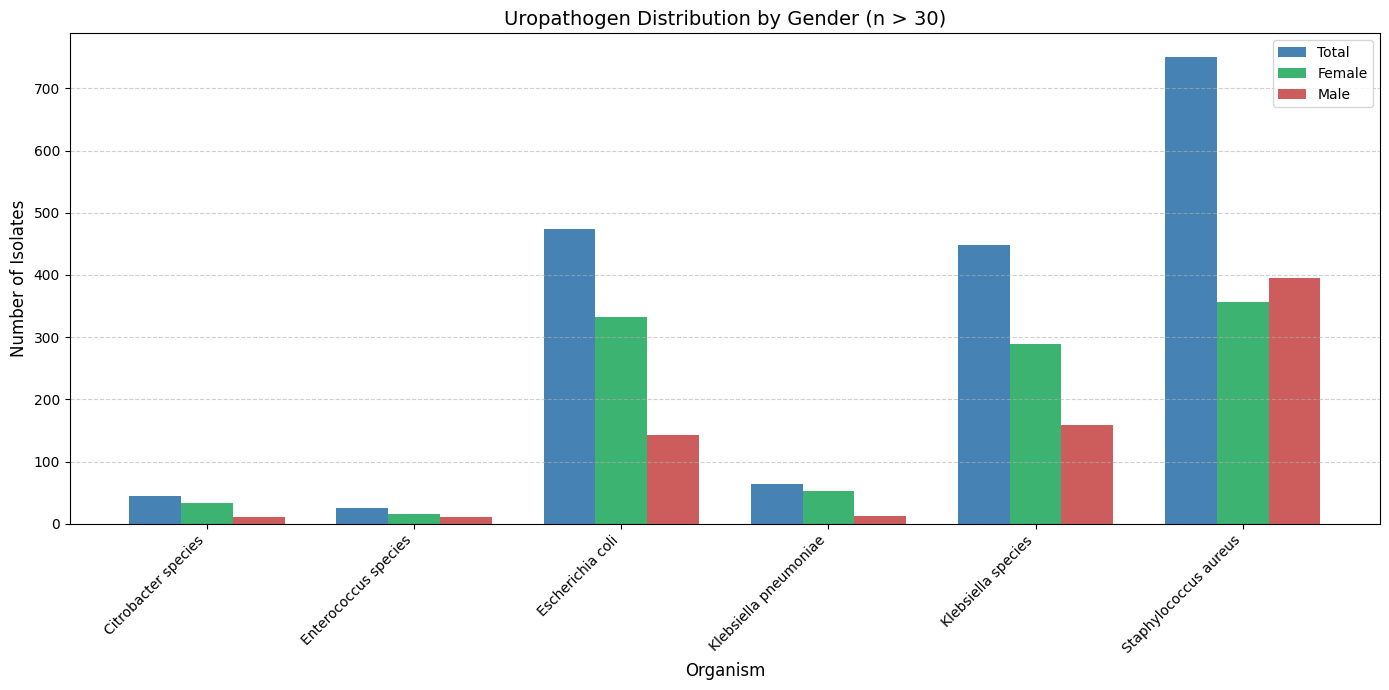

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ✅ Step 1: Recalculate organism counts from updated urine_data
organism_counts = urine_data.groupby(['Organism', 'Sex'], observed=False)['Organism'].size().unstack(fill_value=0)
organism_counts.columns = ['Female', 'Male']
organism_counts['Total'] = organism_counts['Female'] + organism_counts['Male']

# ✅ Step 2: Prepare bar positions
bar_width = 0.25
r1 = np.arange(len(organism_counts))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# ✅ Step 3: Plot the bar chart
fig, ax = plt.subplots(figsize=(14, 7))  # Wider for label spacing

ax.bar(r1, organism_counts['Total'], color='steelblue', width=bar_width, label='Total')
ax.bar(r2, organism_counts['Female'], color='mediumseagreen', width=bar_width, label='Female')
ax.bar(r3, organism_counts['Male'], color='indianred', width=bar_width, label='Male')

# ✅ Step 4: Annotate plot
ax.set_xlabel('Organism', fontsize=12)
ax.set_ylabel('Number of Isolates', fontsize=12)
ax.set_title('Uropathogen Distribution by Gender (n > 30)', fontsize=14)
ax.set_xticks([r + bar_width for r in range(len(organism_counts))])
ax.set_xticklabels(organism_counts.index, rotation=45, ha='right', fontsize=10)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [ ]:
# Define age bins and labels
bins = [0, 15, 26, 36, 46, 66, float('inf')]  # Define bin edges
labels = ['0-14', '15-25', '26-35', '36-45', '46-65', '>65']  # Define labels

# Assign Age Group to the DataFrame
urine_data['Age Group'] = pd.cut(urine_data['Age'], bins=bins, labels=labels, right=False)


In [ ]:
# prompt: code to calculate organism_counts_by_age_group
organism_counts_by_age_group = urine_data.groupby(['Organism', 'Age Group'])['Organism'].count().unstack(fill_value=0)
organism_counts_by_age_group

<ipython-input-118-bdd9d3b85bbc>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  organism_counts_by_age_group = urine_data.groupby(['Organism', 'Age Group'])['Organism'].count().unstack(fill_value=0)


Age Group,0-14,15-25,26-35,36-45,46-65,>65
Organism,,,,,,
Citrobacter species,3,5,7,12,11,6
Enterococcus species,0,2,7,9,5,3
Escherichia coli,25,77,88,98,113,73
Klebsiella pneumoniae,6,14,10,12,21,1
Klebsiella species,17,73,137,82,93,46
Staphylococcus aureus,21,177,220,137,152,44


In [ ]:
#list organisms
print(urine_data['Organism'].unique())

['Escherichia coli' 'Klebsiella species' 'Staphylococcus aureus'
 'Enterococcus species' 'Klebsiella pneumoniae' 'Citrobacter species']


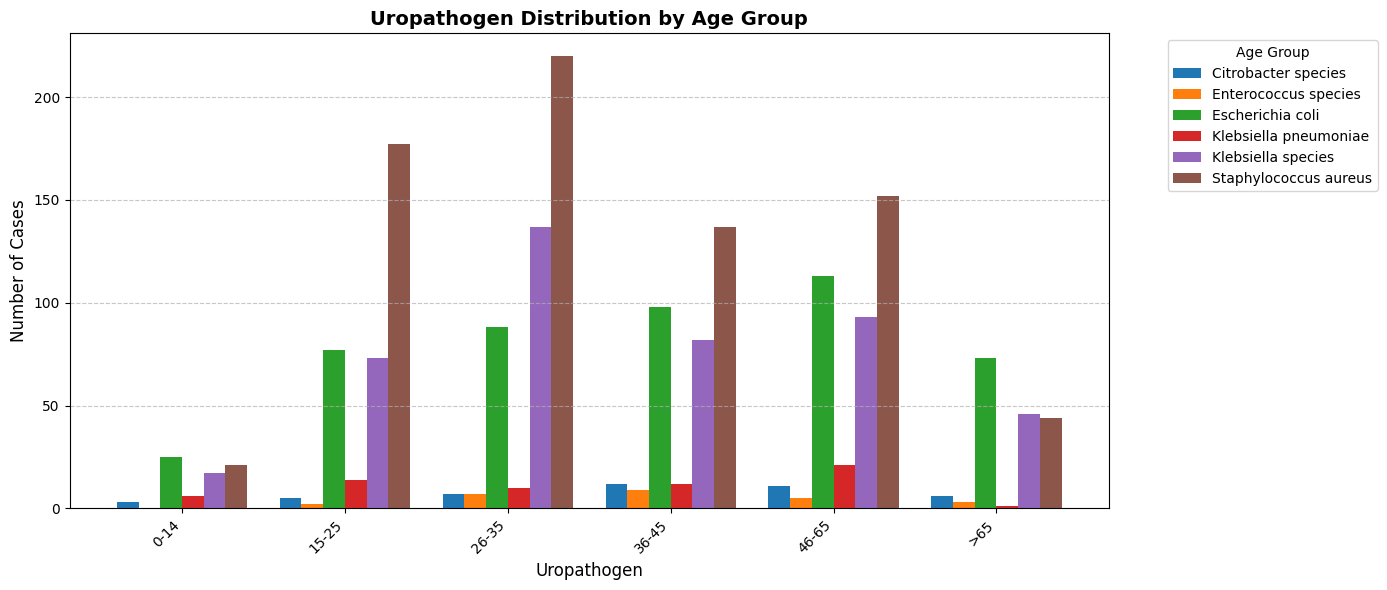

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure "Other Organisms" is last
if "Other Organisms" in organism_counts_by_age_group.index:
    # Move "Other Organisms" to the end
    organism_counts_by_age_group = organism_counts_by_age_group.loc[
        [org for org in organism_counts_by_age_group.index if org != "Other Organisms"] + ["Other Organisms"]
    ]

# Transpose the DataFrame for plotting
organism_counts_by_age_group = organism_counts_by_age_group.T

# Set bar width dynamically based on the number of organisms (age groups) to prevent overlap
num_organisms = len(organism_counts_by_age_group.index)
num_age_groups = len(organism_counts_by_age_group.columns)
bar_width = 0.8 / num_age_groups  # Adjust width to prevent overlap between bars

# Get the positions of the bars on the x-axis (spacing the bars evenly)
x_pos = np.arange(len(organism_counts_by_age_group.index))

# Create the grouped bar chart
fig, ax = plt.subplots(figsize=(14, 6))  # Increase figure size for better visibility

for i, age_group in enumerate(organism_counts_by_age_group.columns):
    ax.bar(x_pos + i * bar_width, organism_counts_by_age_group[age_group], width=bar_width, label=age_group)

# Customize the chart
ax.set_xlabel('Uropathogen', fontsize=12)
ax.set_ylabel('Number of Cases', fontsize=12)
ax.set_title('Uropathogen Distribution by Age Group', fontsize=14, fontweight='bold')

# Adjust X-axis labels to prevent overlapping
ax.set_xticks(x_pos + bar_width * (num_age_groups / 2) - bar_width / 2)  # Adjusting for proper centering
ax.set_xticklabels(organism_counts_by_age_group.index, rotation=45, ha='right')

# Add a grid for better readability
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Add a legend with a title
ax.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')

# Improve layout to prevent clipping of labels
plt.tight_layout()

# Display the chart
plt.show()


In [ ]:
import pandas as pd

# ... (your previous code to load, process, and encode urine_data) ...

# Select columns containing antibiotic data (encoded columns)
antibiotic_columns = urine_data.columns[urine_data.columns.str.endswith(('_I', '_R', '_S'))]  # Corrected line

# Create a dictionary to store the counts
antibiotic_counts = {}

# Iterate through antibiotic columns and count I, R, S
for column in antibiotic_columns:
    antibiotic_name = column[:-2]  # Extract antibiotic name from column name

    # Get the category (I, R, or S) from the column name
    category = column[-1]

    # Store the count in the dictionary, creating a new entry for the antibiotic if needed
    if antibiotic_name not in antibiotic_counts:
        antibiotic_counts[antibiotic_name] = {'I': 0, 'R': 0, 'S': 0}  # Initialize counts to 0

    antibiotic_counts[antibiotic_name][category] = urine_data[column].sum()
# Convert the dictionary to a DataFrame for better display
antibiotic_counts_df = pd.DataFrame(antibiotic_counts).T
antibiotic_counts_df.index.name = 'Antibiotic'
# Display the results
print(antibiotic_counts_df)

print(len(urine_data))

                              I     R     S
Antibiotic                                 
Amoxicillin                   1   141    48
Amoxicillin/Clavulanic Acid  12   516   608
Ampicillin                    4   435    43
Azlocillin                    0     1     0
Aztreonam                     3    33    19
Cefaclor                      1    20    13
Cefazolin                     5   313   243
Ceftazidime                   0    91   179
Cefotaxime                    3   240   712
Ceftriaxone                  11   486   681
Ciprofloxacin                30   266   842
Clindamycin                   2   455   607
Chloramphenicol              10   841   505
Chlortetracycline             1     2    28
Erythromycin                  8   405   266
Gentamicin                   11   287   980
Imipenem                     13    69  1070
Meropenem                     2     6    60
Moxifloxacin                  1     5   158
Nitrofurantoin               34    64   419
Ofloxacin                     0 

In [ ]:
encoded_columns = urine_data.columns[urine_data.columns.str.endswith(('_I', '_R', '_S'))]
for col in encoded_columns:
       urine_data[col] = urine_data[col].astype(int)  # Convert to integers if necessary
       urine_data[col] = urine_data[col].clip(0, 1)  # Clip values to be between 0 and 1

In [ ]:
#Let us remove the antibiotics that have only zeros for I, R and S from our encoded columns


In [ ]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

import pandas as pd
from IPython.display import display

# Select encoded antibiotic susceptibility columns
antibiotic_columns = urine_data.columns[urine_data.columns.str.endswith(('_I', '_R', '_S'))]

# Initialize dictionary for counting
antibiotic_counts = {}

for column in antibiotic_columns:
    antibiotic_name = column[:-2]  # Strip suffix (_R/_S/_I)
    category = column[-1]         # Get suffix (R/S/I)

    if antibiotic_name not in antibiotic_counts:
        antibiotic_counts[antibiotic_name] = {'Resistant': 0, 'Sensitive': 0, 'Total Culture': 0}

    if category in ('I', 'R'):
        antibiotic_counts[antibiotic_name]['Resistant'] += urine_data[column].sum()
    elif category == 'S':
        antibiotic_counts[antibiotic_name]['Sensitive'] += urine_data[column].sum()

    # Update total
    antibiotic_counts[antibiotic_name]['Total Culture'] = (
        antibiotic_counts[antibiotic_name]['Resistant'] +
        antibiotic_counts[antibiotic_name]['Sensitive']
    )

# Construct table
antimicrobial_agents = list(antibiotic_counts.keys())
table_data = {
    'Antimicrobial\nAgents': antimicrobial_agents,
    'No. of Cultures Tested': [],
    'Resistant No (%)': []
}

for agent in antimicrobial_agents:
    total = antibiotic_counts[agent]['Total Culture']
    r = antibiotic_counts[agent]['Resistant']

    table_data['No. of Cultures Tested'].append(total)
    table_data['Resistant No (%)'].append(f"{r} ({r / total * 100:.1f}%)" if total else '0 (0.0%)')

# Create and sort DataFrame
susceptibility_table = pd.DataFrame(table_data)
susceptibility_table = susceptibility_table.sort_values(by='Antimicrobial\nAgents')

# Display using Colab’s interactive table
display(data_table.DataTable(susceptibility_table))


,Antimicrobial\nAgents,No. of Cultures Tested,Resistant No (%)
0,Amoxicillin,190,142 (74.7%)
1,Amoxicillin/Clavulanic Acid,1136,528 (46.5%)
2,Ampicillin,482,439 (91.1%)
3,Azlocillin,1,1 (100.0%)
4,Aztreonam,55,36 (65.5%)
5,Cefaclor,34,21 (61.8%)
6,Cefazolin,561,318 (56.7%)
8,Cefotaxime,955,243 (25.4%)
25,Cefoxitin 30 mg,95,36 (37.9%)
7,Ceftazidime,270,91 (33.7%)


In [ ]:
import pandas as pd
from google.colab import data_table

data_table.enable_dataframe_formatter()

# ... (your existing code to load and preprocess urine_data) ...

# Get unique organisms and antimicrobial agents
unique_organisms = urine_data['Organism'].unique()
antibiotic_columns = urine_data.columns[urine_data.columns.str.endswith(('_I', '_R', '_S'))]
antimicrobial_agents = list(set([col[:-2] for col in antibiotic_columns]))

# Create a dictionary to store the table data (organisms as rows, antibiotics as columns)
table_data = {}

# Loop through organisms and antimicrobial agents to populate the table
for organism in unique_organisms:
    for agent in antimicrobial_agents:
        # Create keys for 'T' and 'RNo (%)' for each organism-antibiotic pair
        total_key = organism + ' T_' + agent  # Unique key for Total
        rno_key = organism + ' RNo (%)_' + agent  # Unique key for RNo (%)

        try:
            # Calculate total tested and resistant count
            total_tested = urine_data.loc[urine_data['Organism'] == organism, [agent + '_I', agent + '_R', agent + '_S']].sum().sum()
            #resistant_count = filtered_data.loc[filtered_data['Organism'] == organism, [agent + '_I', agent + '_R']].sum().sum()
            resistant_count = urine_data.loc[urine_data['Organism'] == organism, [agent + '_I', agent + '_R',]].sum().sum()

            # Store values in the table_data dictionary
            table_data[total_key] = total_tested
            table_data[rno_key] = f"{resistant_count} ({resistant_count / total_tested * 100:.1f})" if total_tested else 'ND'

        except KeyError:
            # Handle cases where the agent is not found for the current organism
            table_data[total_key] = 'ND'
            table_data[rno_key] = 'ND'

# Create the DataFrame
susceptibility_table = pd.DataFrame([table_data]).T.rename(columns={0: 'Value'})

# Split the index values safely with conditional checks
susceptibility_table['Organism'] = susceptibility_table.index.map(lambda x: x.split(' T_')[0] if ' T_' in x else x.split(' RNo (%)_')[0])
susceptibility_table['Type'] = susceptibility_table.index.map(lambda x: 'T' if ' T_' in x else 'RNo (%)')
susceptibility_table['Antibiotic'] = susceptibility_table.index.map(lambda x: x.split(' T_')[1] if ' T_' in x else x.split(' RNo (%)_')[1])

# Reshape the DataFrame to have organisms as rows
susceptibility_table = susceptibility_table.set_index(['Organism', 'Type', 'Antibiotic'])['Value'].unstack('Antibiotic')
#remove all antibiotics that have only ND values throughout
susceptibility_table = susceptibility_table.loc[:, (susceptibility_table != 'ND').any(axis=0)]
#sort ascending
susceptibility_table = susceptibility_table.sort_values(by='Organism', ascending=True)

# Display the table using data_table formatter
display(susceptibility_table)

Antibiotic                    Amoxicillin Amoxicillin/Clavulanic Acid  \
Organism              Type                                              
Citrobacter species   RNo (%)          ND                   12 (80.0)   
                      T                 0                          15   
Enterococcus species  RNo (%)     0 (0.0)                    2 (13.3)   
                      T                 2                          15   
Escherichia coli      RNo (%)   27 (65.9)                  147 (56.8)   
                      T                41                         259   
Klebsiella pneumoniae RNo (%)          ND                   30 (76.9)   
                      T                 0                          39   
Klebsiella species    RNo (%)   42 (75.0)                  146 (47.1)   
                      T                56                         310   
Staphylococcus aureus RNo (%)   73 (80.2)                  191 (38.4)   
                      T                91                         498   

Antibiotic                     Ampicillin  Aztreonam  Cefaclor   Cefazolin  \
Organism              Type                                                   
Citrobacter species   RNo (%)   3 (100.0)   3 (60.0)        ND          ND   
                      T                 3          5         0           0   
Enterococcus species  RNo (%)    5 (45.5)         ND        ND    1 (33.3)   
                      T                11          0         0           3   
Escherichia coli      RNo (%)  193 (90.6)  23 (65.7)  7 (63.6)   48 (32.9)   
                      T               213         35        11         146   
Klebsiella pneumoniae RNo (%)   30 (96.8)   2 (40.0)   0 (0.0)   11 (40.7)   
                      T                31          5         1          27   
Klebsiella species    RNo (%)   98 (97.0)   3 (75.0)  8 (57.1)   72 (69.9)   
                      T               101          4        14         103   
Staphylococcus aureus RNo (%)  110 (89.4)   5 (83.3)  6 (75.0)  186 (66.0)   
                      T               123          6         8         282   

Antibiotic                     Cefotaxime Cefoxitin 30 mg Ceftriaxone  \
Organism              Type                                              
Citrobacter species   RNo (%)   3 (100.0)       1 (100.0)   15 (57.7)   
                      T                 3               1          26   
Enterococcus species  RNo (%)     0 (0.0)              ND    4 (30.8)   
                      T                 9               0          13   
Escherichia coli      RNo (%)   45 (30.2)       15 (45.5)  125 (48.1)   
                      T               149              33         260   
Klebsiella pneumoniae RNo (%)    6 (50.0)        3 (30.0)   17 (65.4)   
                      T                12              10          26   
Klebsiella species    RNo (%)   76 (23.4)        2 (22.2)  141 (38.7)   
                      T               325               9         364   
Staphylococcus aureus RNo (%)  113 (24.7)       15 (35.7)  195 (39.9)   
                      T               457              42         489   

Antibiotic                    Chloramphenicol  ... Erythromycin  Gentamicin  \
Organism              Type                     ...                            
Citrobacter species   RNo (%)        5 (62.5)  ...    2 (100.0)    5 (55.6)   
                      T                     8  ...            2           9   
Enterococcus species  RNo (%)        7 (70.0)  ...    16 (72.7)    2 (14.3)   
                      T                    10  ...           22          14   
Escherichia coli      RNo (%)      110 (44.9)  ...    13 (86.7)   57 (19.5)   
                      T                   245  ...           15         293   
Klebsiella pneumoniae RNo (%)       15 (38.5)  ...    3 (100.0)   11 (33.3)   
                      T                    39  ...            3          33   
Klebsiella species    RNo (%)      272 (67.8)  ...    10 (71.4)   61 (1

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#export the dataframe to csv
susceptibility_table.to_csv('/content/drive/My Drive/susceptibility_table.csv', index=True)
df_verify = pd.read_csv('/content/drive/My Drive/susceptibility_table.csv')
#print(df_verify)


In [ ]:
#display all antibiotic columns
print("Antibiotic Columns:")
for column in antibiotic_columns:
    print(column)

Antibiotic Columns:
Amoxicillin_I
Amoxicillin_R
Amoxicillin_S
Amoxicillin/Clavulanic Acid_I
Amoxicillin/Clavulanic Acid_R
Amoxicillin/Clavulanic Acid_S
Ampicillin_I
Ampicillin_R
Ampicillin_S
Azlocillin_R
Azlocillin_S
Aztreonam_I
Aztreonam_R
Aztreonam_S
Cefaclor_I
Cefaclor_R
Cefaclor_S
Cefazolin_I
Cefazolin_R
Cefazolin_S
Ceftazidime_R
Ceftazidime_S
Cefotaxime_I
Cefotaxime_R
Cefotaxime_S
Ceftriaxone_I
Ceftriaxone_R
Ceftriaxone_S
Ciprofloxacin_I
Ciprofloxacin_R
Ciprofloxacin_S
Clindamycin_I
Clindamycin_R
Clindamycin_S
Chloramphenicol_I
Chloramphenicol_R
Chloramphenicol_S
Chlortetracycline_I
Chlortetracycline_R
Chlortetracycline_S
Erythromycin_I
Erythromycin_R
Erythromycin_S
Gentamicin_I
Gentamicin_R
Gentamicin_S
Imipenem_I
Imipenem_R
Imipenem_S
Meropenem_I
Meropenem_R
Meropenem_S
Moxifloxacin_I
Moxifloxacin_R
Moxifloxacin_S
Nitrofurantoin_I
Nitrofurantoin_R
Nitrofurantoin_S
Ofloxacin_R
Ofloxacin_S
Oxacillin_I
Oxacillin_R
Oxacillin_S
Vancomycin_I
Vancomycin_R
Vancomycin_S
Penicillin_I
Peni

In [ ]:
import pandas as pd

# Define antibiotic classes with Chloramphenicol and Nitrofurantoin in correct classes
antibiotic_classes = {
    'Beta-lactams': ['Amoxicillin', 'Amoxicillin/Clavulanic Acid', 'Ampicillin', 'Azlocillin', 'Aztreonam',
                     'Cefaclor', 'Cefazolin', 'Ceftriaxone', 'Penicillin'],
    'Fluoroquinolones': ['Ciprofloxacin', 'Ofloxacin', 'Moxifloxacin'],
    'Aminoglycosides': ['Gentamicin'],
    'Macrolides': ['Clindamycin', 'Erythromycin'],
    'Tetracyclines': ['Chlortetracycline'],
    'Sulfonamides': ['Sulfamethoxazole'],
    'Carbapenems': ['Imipenem', 'Meropenem'],
    'Amphenicols': ['Chloramphenicol'],
    'Nitrofurans': ['Nitrofurantoin']
}


# Initialize a list to store resistant classes for each isolate
resistant_classes_list = []

# Iterate over each row (isolate) in the dataset
for index, row in urine_data.iterrows():
    resistant_classes = []  # Stores resistant classes for current isolate

    # Check for resistance in each antibiotic class
    for class_name, antibiotics in antibiotic_classes.items():
        for antibiotic in antibiotics:
            antibiotic_resistant_col = f"{antibiotic}_R"  # Column name for resistance

            # Check if the column exists and if the isolate is resistant (value = 1)
            if antibiotic_resistant_col in row and row[antibiotic_resistant_col] == 1:
                resistant_classes.append(class_name)  # Add class to the list
                break  # No need to check other antibiotics in this class

    # Convert list to comma-separated string for easier readability
    resistant_classes_str = ', '.join(resistant_classes)

    # Append the resistant classes for this isolate
    resistant_classes_list.append(resistant_classes_str)

# Add the new column to the dataset
urine_data['Resistant Classes'] = resistant_classes_list

# Display updated dataset with the new column
import IPython.display as display
#display.display(urine_data[['Identification number', 'Specimen number', 'Organism', 'Resistant Classes']])
# Function to classify MDR type based on organism and resistance profile
def determine_mdr_type(row):
    organism = row['Organism'].lower()
    mdr_types = []

    # ESBL: E. coli, Klebsiella, Citrobacter with resistance to 3rd-gen cephalosporins
    if any(o in organism for o in ['escherichia coli', 'klebsiella', 'citrobacter']) and \
       any(row.get(f"{ab}_R", 0) == 1 for ab in ['Ceftriaxone', 'Ceftazidime', 'Cefotaxime']):
        mdr_types.append('ESBL')

    # MRSA: Staphylococcus aureus resistant to Oxacillin or Cefoxitin
    if 'staphylococcus aureus' in organism and \
       any(row.get(f"{ab}_R", 0) == 1 for ab in ['Oxacillin', 'Cefoxitin 30 mg']):
        mdr_types.append('MRSA')

    # VRE: Enterococcus resistant to Vancomycin
    if 'enterococcus' in organism and row.get('Vancomycin_R', 0) == 1:
        mdr_types.append('VRE')

    # KPC: Klebsiella pneumoniae resistant to Imipenem or Meropenem
    if 'klebsiella pneumoniae' in organism and \
       any(row.get(f"{ab}_R", 0) == 1 for ab in ['Imipenem', 'Meropenem']):
        mdr_types.append('KPC')

    return ', '.join(mdr_types) if mdr_types else 'None'


# Function to classify general MDR status by class count
def classify_mdr(resistant_classes):
    if isinstance(resistant_classes, str):
        cleaned = [cls.strip() for cls in resistant_classes.split(',') if cls.strip()]
        return 'MDR' if len(cleaned) >= 3 else 'Non-MDR'
    return 'Non-MDR'


# Apply both classifications
urine_data['MDR Status'] = urine_data['Resistant Classes'].apply(classify_mdr)
urine_data['MDR Type'] = urine_data.apply(determine_mdr_type, axis=1)

# Display summary
mdr_counts = urine_data['MDR Status'].value_counts()
print("MDR Status Summary:\n", mdr_counts)

#mdr_type_counts = urine_data['MDR Type'].value_counts()
#print("\nMDR Types Summary:\n", mdr_type_counts)
summary_table = urine_data.groupby(['MDR Status', 'MDR Type']).size().reset_index(name='Count')
display.display(summary_table)

# Show MDR isolates
mdr_isolates = urine_data[urine_data['MDR Status'] == 'MDR']
import IPython.display as display
display.display(mdr_isolates[['Identification number', 'Specimen number', 'Organism', 'Resistant Classes', 'MDR Status', 'MDR Type']])



MDR Status Summary:
 MDR Status
MDR        1122
Non-MDR     746
Name: count, dtype: int64


,MDR Status,MDR Type,Count
0,MDR,ESBL,250
1,MDR,"ESBL, KPC",1
2,MDR,KPC,1
3,MDR,MRSA,32
4,MDR,None,837
5,MDR,VRE,1
6,Non-MDR,ESBL,137
7,Non-MDR,KPC,1
8,Non-MDR,MRSA,19
9,Non-MDR,None,589


,Identification number,Specimen number,Organism,Resistant Classes,MDR Status,MDR Type
40,O-0144,NaN,Escherichia coli,"Beta-lactams, Sulfonamides, Amphenicols",MDR,ESBL
59,O-0131,NaN,Klebsiella species,"Beta-lactams, Fluoroquinolones, Macrolides",MDR,ESBL
88,O-0096,NaN,Klebsiella species,"Beta-lactams, Macrolides, Sulfonamides, Amphen...",MDR,None
99,O-0086,NaN,Klebsiella species,"Beta-lactams, Sulfonamides, Amphenicols",MDR,ESBL
100,O-0087,NaN,Staphylococcus aureus,"Beta-lactams, Macrolides, Sulfonamides",MDR,None
...,...,...,...,...,...,...
23569,0-1127,NaN,Klebsiella species,"Beta-lactams, Aminoglycosides, Sulfonamides, A...",MDR,ESBL
23572,0-1130,NaN,Klebsiella species,"Aminoglycosides, Macrolides, Sulfonamides, Amp...",MDR,None
23573,0-1131,NaN,Klebsiella species,"Beta-lactams, Fluoroquinolones, Sulfonamides, ...",MDR,ESBL
23574,0-1132,NaN,Staphylococcus aureus,"Beta-lactams, Fluoroquinolones, Macrolides, Su...",MDR,None


In [ ]:
# Function to determine MDR status
def classify_mdr(resistant_classes):
    if isinstance(resistant_classes, str):  # Ensure it's a string before splitting
        num_classes = len(resistant_classes.split(', '))
        return 'MDR' if num_classes >= 3 else 'Non-MDR'
    return 'Non-MDR'  # Default to Non-MDR if no resistance

# Apply MDR classification
filtered_data['MDR Status'] = filtered_data['Resistant Classes'].apply(classify_mdr)

# Display MDR statistics
mdr_counts = filtered_data['MDR Status'].value_counts()
print(mdr_counts)

# Display MDR isolates only
mdr_isolates = filtered_data[filtered_data['MDR Status'] == 'MDR']
import IPython.display as display
display.display(mdr_isolates[['Identification number', 'Specimen number', 'Organism', 'Resistant Classes', 'MDR Status']])

MDR Status
MDR        281
Non-MDR    269
Name: count, dtype: int64


,Identification number,Specimen number,Organism,Resistant Classes,MDR Status
209,O-1835,NaN,Escherichia coli,"Beta-lactams, Macrolides, Sulfonamides, Others",MDR
236,O-1809,NaN,Staphylococcus aureus,"Beta-lactams, Macrolides, Sulfonamides, Others",MDR
244,O-1798,NaN,Klebsiella species,"Beta-lactams, Sulfonamides, Others",MDR
261,O-1782,NaN,Staphylococcus aureus,"Beta-lactams, Macrolides, Sulfonamides, Others",MDR
276,O-1780,NaN,Staphylococcus aureus,"Beta-lactams, Macrolides, Sulfonamides, Others",MDR
...,...,...,...,...,...
4362,0-0063,NaN,Klebsiella species,"Beta-lactams, Macrolides, Others",MDR
4408,O-0061,NaN,Klebsiella species,"Beta-lactams, Macrolides, Sulfonamides, Others",MDR
4417,O-0051,NaN,Escherichia coli,"Beta-lactams, Macrolides, Sulfonamides",MDR
4427,O-0029,NaN,Escherichia coli,"Beta-lactams, Macrolides, Carbapenems",MDR


In [ ]:
import pandas as pd

# Create a table showing the MDR vs. Non-MDR distribution for each organism in the filtered_data DataFrame.
mdr_distribution_table = filtered_data.groupby(['Organism', 'MDR Status'])['MDR Status'].count().unstack(fill_value=0)

# Rename columns for clarity
mdr_distribution_table = mdr_distribution_table.rename(columns={'MDR': 'MDR Count', 'Non-MDR': 'Non-MDR Count'})

# Add a total column
mdr_distribution_table['Total'] = mdr_distribution_table['MDR Count'] + mdr_distribution_table['Non-MDR Count']

# Calculate percentages
mdr_distribution_table['MDR Percentage'] = (mdr_distribution_table['MDR Count'] / mdr_distribution_table['Total']) * 100
mdr_distribution_table['Non-MDR Percentage'] = (mdr_distribution_table['Non-MDR Count'] / mdr_distribution_table['Total']) * 100

# Format percentage columns to one decimal place
mdr_distribution_table['MDR Percentage'] = mdr_distribution_table['MDR Percentage'].map('{:.1f}'.format)
mdr_distribution_table['Non-MDR Percentage'] = mdr_distribution_table['Non-MDR Percentage'].map('{:.1f}'.format)


In [ ]:
import pandas as pd
from IPython.display import display


# ... (your previous code to create mdr_distribution_table) ...

# Create new columns for formatted output
mdr_distribution_table['MDR (n, %)'] = mdr_distribution_table.apply(
    lambda row: f"{row['MDR Count']} ({row['MDR Percentage']})", axis=1
)
mdr_distribution_table['Non-MDR (n, %)'] = mdr_distribution_table.apply(
    lambda row: f"{row['Non-MDR Count']} ({row['Non-MDR Percentage']})", axis=1
)

# Select and reorder columns for display
mdr_distribution_table = mdr_distribution_table[['MDR (n, %)','Non-MDR (n, %)','Total']]

# Display the reformatted table
display(mdr_distribution_table)

MDR Status,"MDR (n, %)","Non-MDR (n, %)",Total
Organism,,,
Corynebacterium species,8 (66.7),4 (33.3),12
Enterobacter species,5 (62.5),3 (37.5),8
Enterococcus species,7 (35.0),13 (65.0),20
Escherichia coli,101 (52.9),90 (47.1),191
Klebsiella species,52 (59.8),35 (40.2),87
Neisseria gonorrhoeae,1 (9.1),10 (90.9),11
Other Organisms,8 (53.3),7 (46.7),15
Providencia species,2 (33.3),4 (66.7),6
Pseudomonas species,9 (50.0),9 (50.0),18


<ipython-input-66-32bee723ce22>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=resistant_classes_df.index, y=resistant_classes_df['Count'], palette='Reds_r')


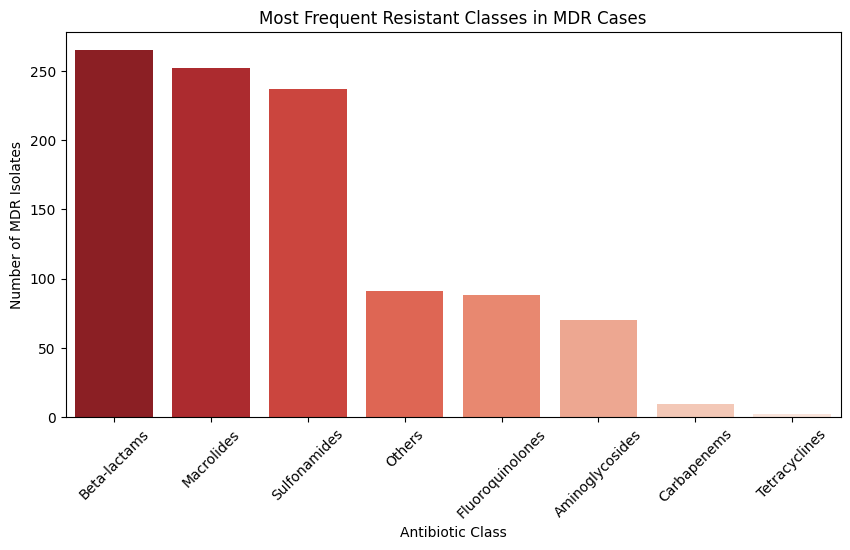

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define antibiotic classes
antibiotic_classes = ['Beta-lactams', 'Fluoroquinolones', 'Aminoglycosides',
                      'Macrolides', 'Tetracyclines', 'Sulfonamides', 'Carbapenems', 'Others']

# Count occurrences of each antibiotic class in MDR cases
resistant_classes_counts = {cls: 0 for cls in antibiotic_classes}

# Loop through MDR data and count occurrences of each resistance class
for classes in mdr_isolates['Resistant Classes'].dropna():
    for cls in classes.split(", "):  # Split multi-class resistance
        if cls in resistant_classes_counts:
            resistant_classes_counts[cls] += 1

# Convert to DataFrame for visualization
resistant_classes_df = pd.DataFrame.from_dict(resistant_classes_counts, orient='index', columns=['Count'])
resistant_classes_df = resistant_classes_df.sort_values(by='Count', ascending=False)

# Plot the results
plt.figure(figsize=(10, 5))
sns.barplot(x=resistant_classes_df.index, y=resistant_classes_df['Count'], palette='Reds_r')
plt.xlabel("Antibiotic Class")
plt.ylabel("Number of MDR Isolates")
plt.title("Most Frequent Resistant Classes in MDR Cases")
plt.xticks(rotation=45)
plt.show()


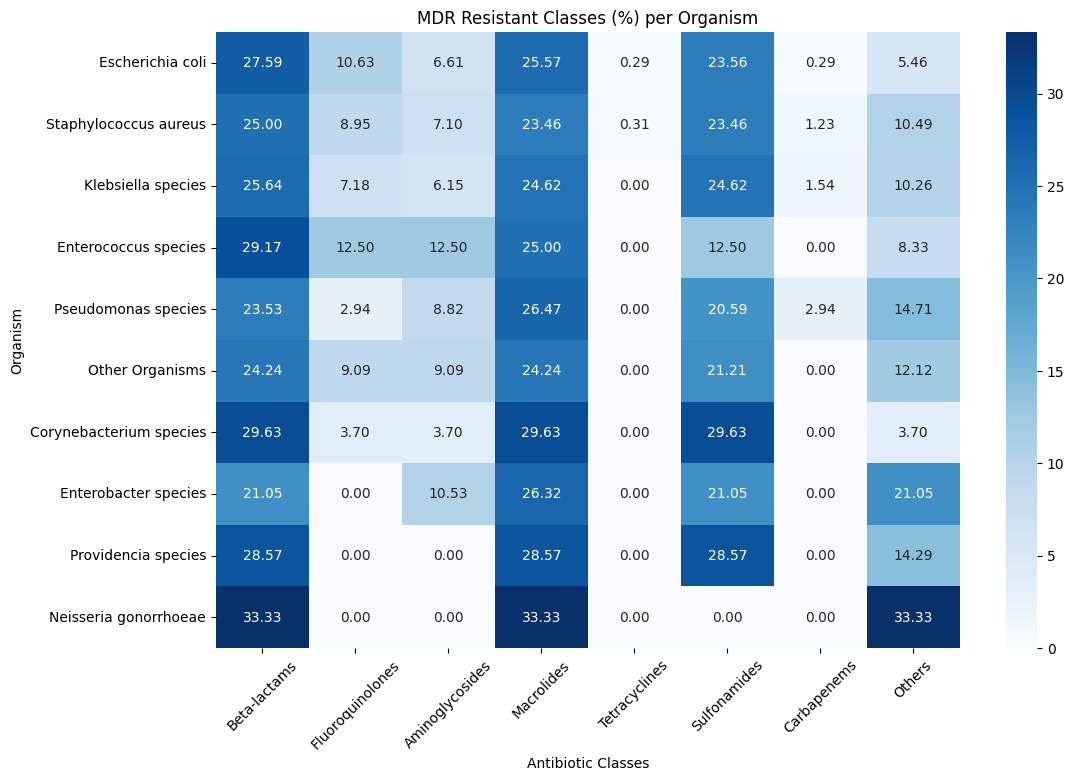

In [ ]:
# Filter MDR organisms only
mdr_data_filtered = mdr_isolates[mdr_isolates['MDR Status'] == 'MDR']

# Initialize a dictionary to hold class counts per organism
organism_class_counts = {}

# Loop through each organism and its corresponding resistant classes
for _, row in mdr_data_filtered.iterrows():
    organism = row['Organism']
    classes = row['Resistant Classes'].split(", ")  # Split multi-class resistance

    # Initialize organism in dictionary if not already present
    if organism not in organism_class_counts:
        organism_class_counts[organism] = {cls: 0 for cls in antibiotic_classes}

    # Count the classes for the current organism
    for cls in classes:
        if cls in organism_class_counts[organism]:
            organism_class_counts[organism][cls] += 1

# Convert to DataFrame for better visualization
organism_class_df = pd.DataFrame.from_dict(organism_class_counts, orient='index')

# Calculate the percentage for each resistance class in each organism
organism_class_percentage = organism_class_df.div(organism_class_df.sum(axis=1), axis=0) * 100
#print organism_class_percentage
#print(organism_class_percentage)

# Plot the results as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(organism_class_percentage, annot=True, cmap='Blues', fmt='.2f', cbar=True)
plt.xlabel("Antibiotic Classes")
plt.ylabel("Organism")
plt.title("MDR Resistant Classes (%) per Organism")
plt.xticks(rotation=45)
plt.show()


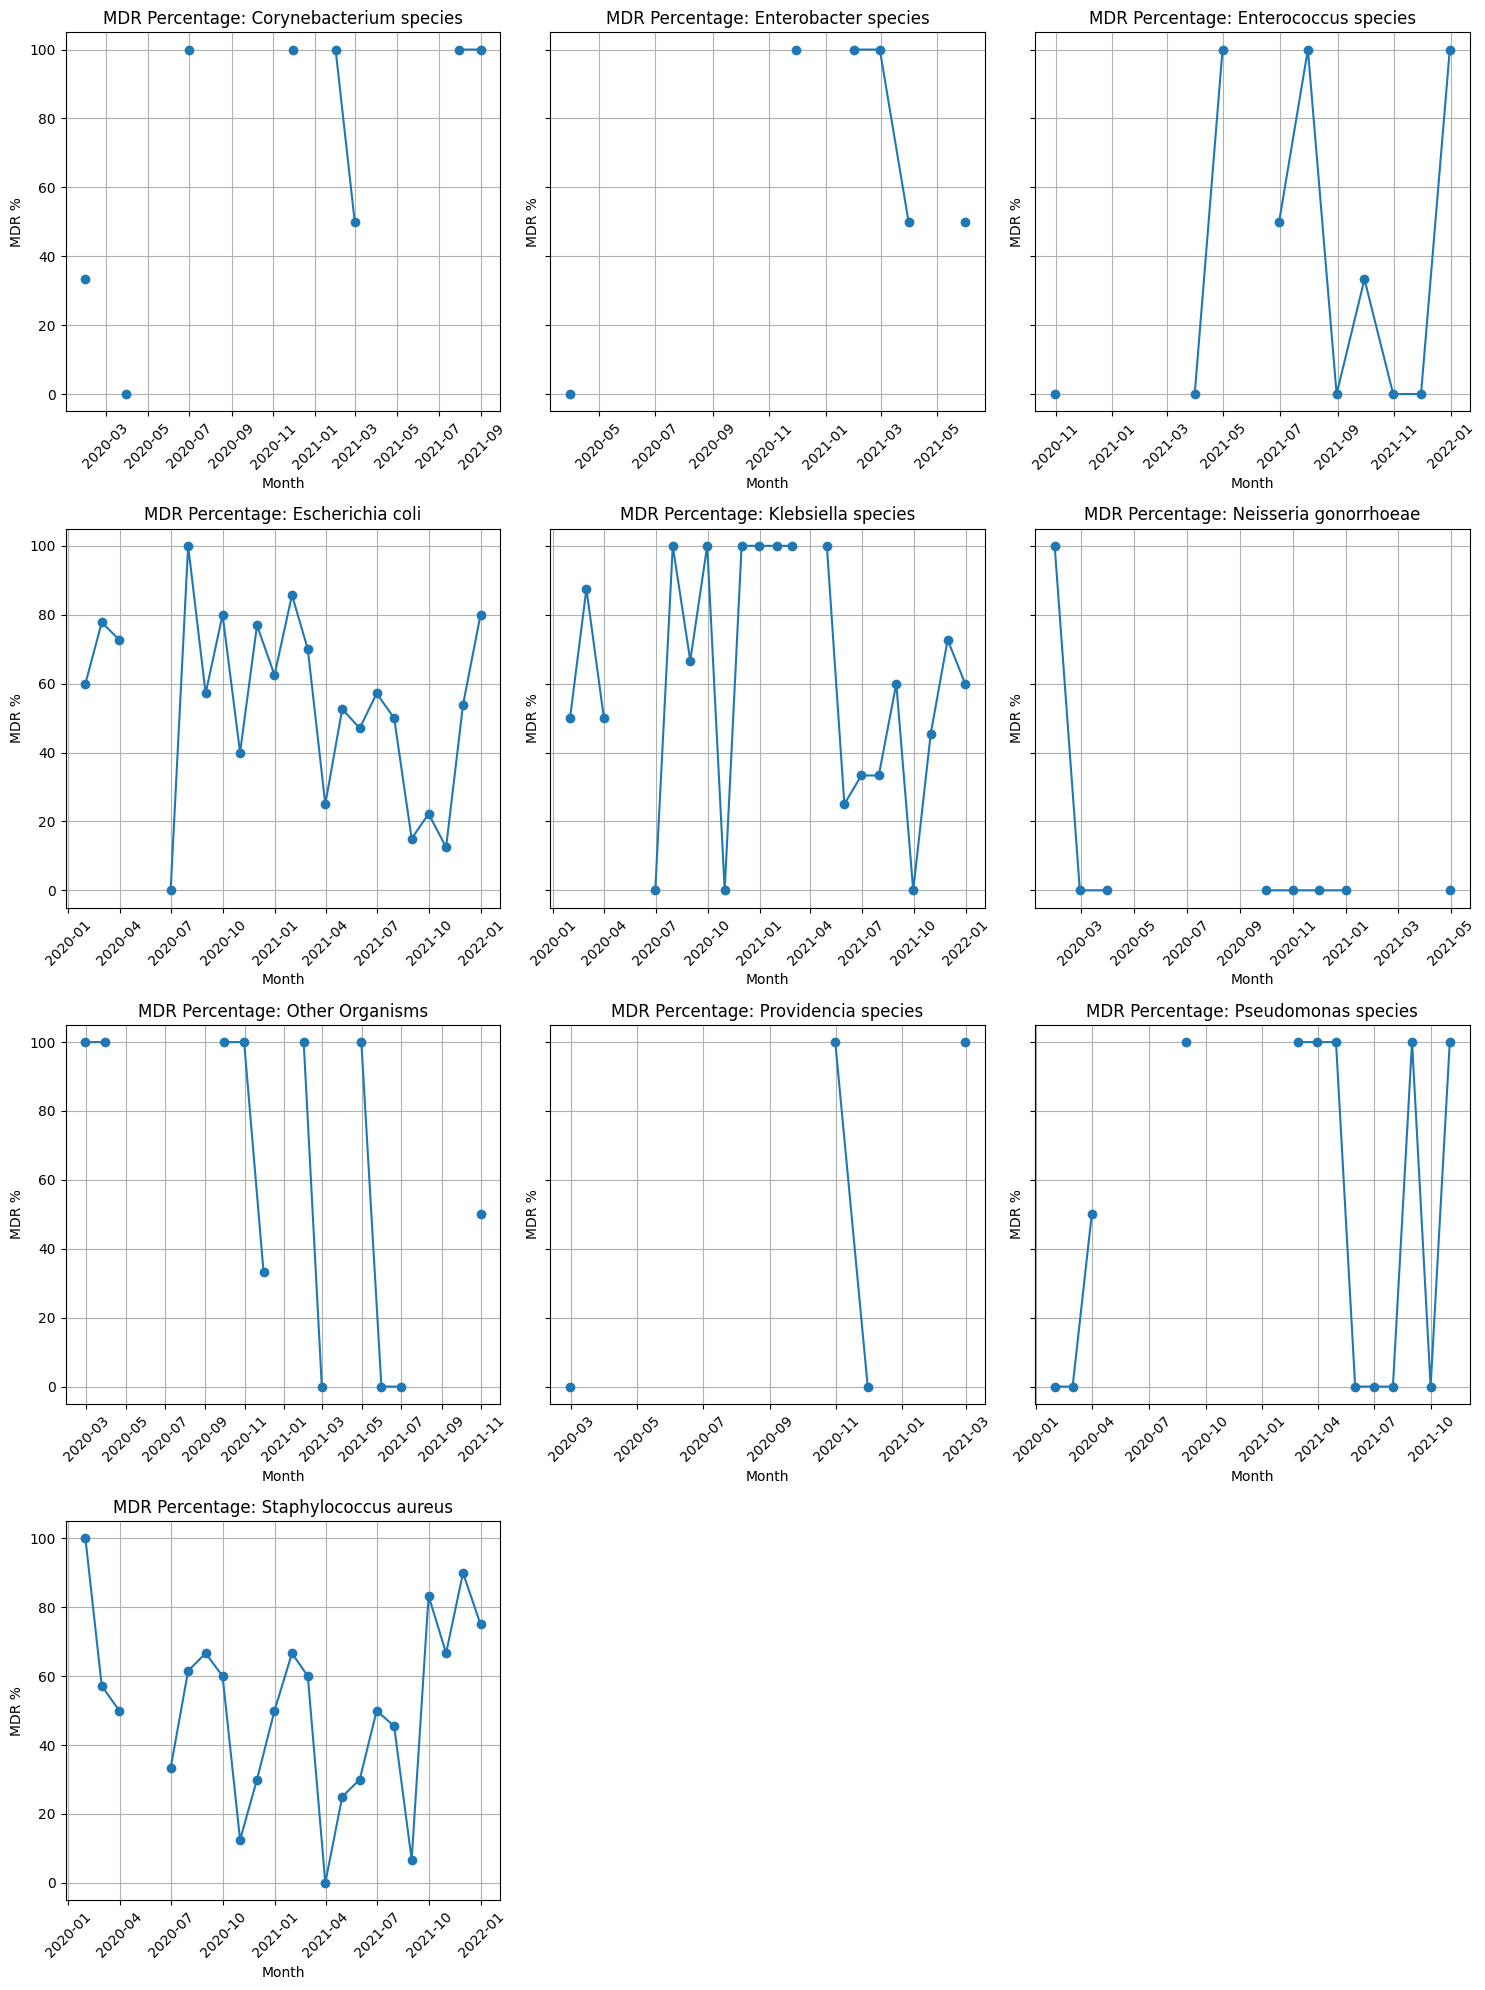

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Ensure 'Specimen date' is in datetime format (using .loc to avoid the SettingWithCopyWarning)
mdr_isolates.loc[:, 'Specimen date'] = pd.to_datetime(mdr_isolates['Specimen date'])

# Filter non-MDR cases
non_mdr_isolates = filtered_data[filtered_data['MDR Status'] == 'Non-MDR']

# Group by 'Specimen date' and 'Organism' to count MDR cases
mdr_time_series = mdr_isolates.groupby([pd.Grouper(key='Specimen date', freq='ME'), 'Organism']).size().unstack(fill_value=0)

# Resample to monthly frequency (month end)
mdr_time_series = mdr_time_series.resample('ME').sum()

# Group by 'Specimen date' and 'Organism' to count non-MDR cases
non_mdr_time_series = non_mdr_isolates.groupby([pd.Grouper(key='Specimen date', freq='ME'), 'Organism']).size().unstack(fill_value=0)

# Resample to monthly frequency (month end)
non_mdr_time_series = non_mdr_time_series.resample('ME').sum()

# Calculate total cases (MDR + Non-MDR) per month per organism
total_time_series = filtered_data.groupby([pd.Grouper(key='Specimen date', freq='ME'), 'Organism']).size().unstack(fill_value=0)
total_time_series = total_time_series.resample('ME').sum()

# Calculate MDR percentage per month using the formula:
mdr_percentage = (mdr_time_series / (mdr_time_series + non_mdr_time_series)) * 100

# Set the number of plots per row (e.g., 3 plots per row)
z = 3  # Change this number to control how many plots per row

# Calculate the number of rows needed based on the number of organisms
num_organisms = len(mdr_percentage.columns)
num_rows = int(np.ceil(num_organisms / z))  # Round up to the nearest integer

# Create the subplot grid with z plots per row
fig, axes = plt.subplots(num_rows, z, figsize=(5 * z, 5 * num_rows), sharey=True)

# Flatten axes array in case we have more than one row
axes = axes.flatten()

# Plot each organism
for idx, organism in enumerate(mdr_percentage.columns):
    ax = axes[idx]
    ax.plot(mdr_percentage.index, mdr_percentage[organism], marker='o', linestyle='-')
    ax.set_title(f'MDR Percentage: {organism}')
    ax.set_xlabel("Month")
    ax.set_ylabel("MDR %")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True)

# Hide any extra empty subplots if there are fewer organisms than grid spaces
for idx in range(num_organisms, len(axes)):
    axes[idx].axis('off')  # Hide the axis for extra subplots

plt.tight_layout()
plt.show()


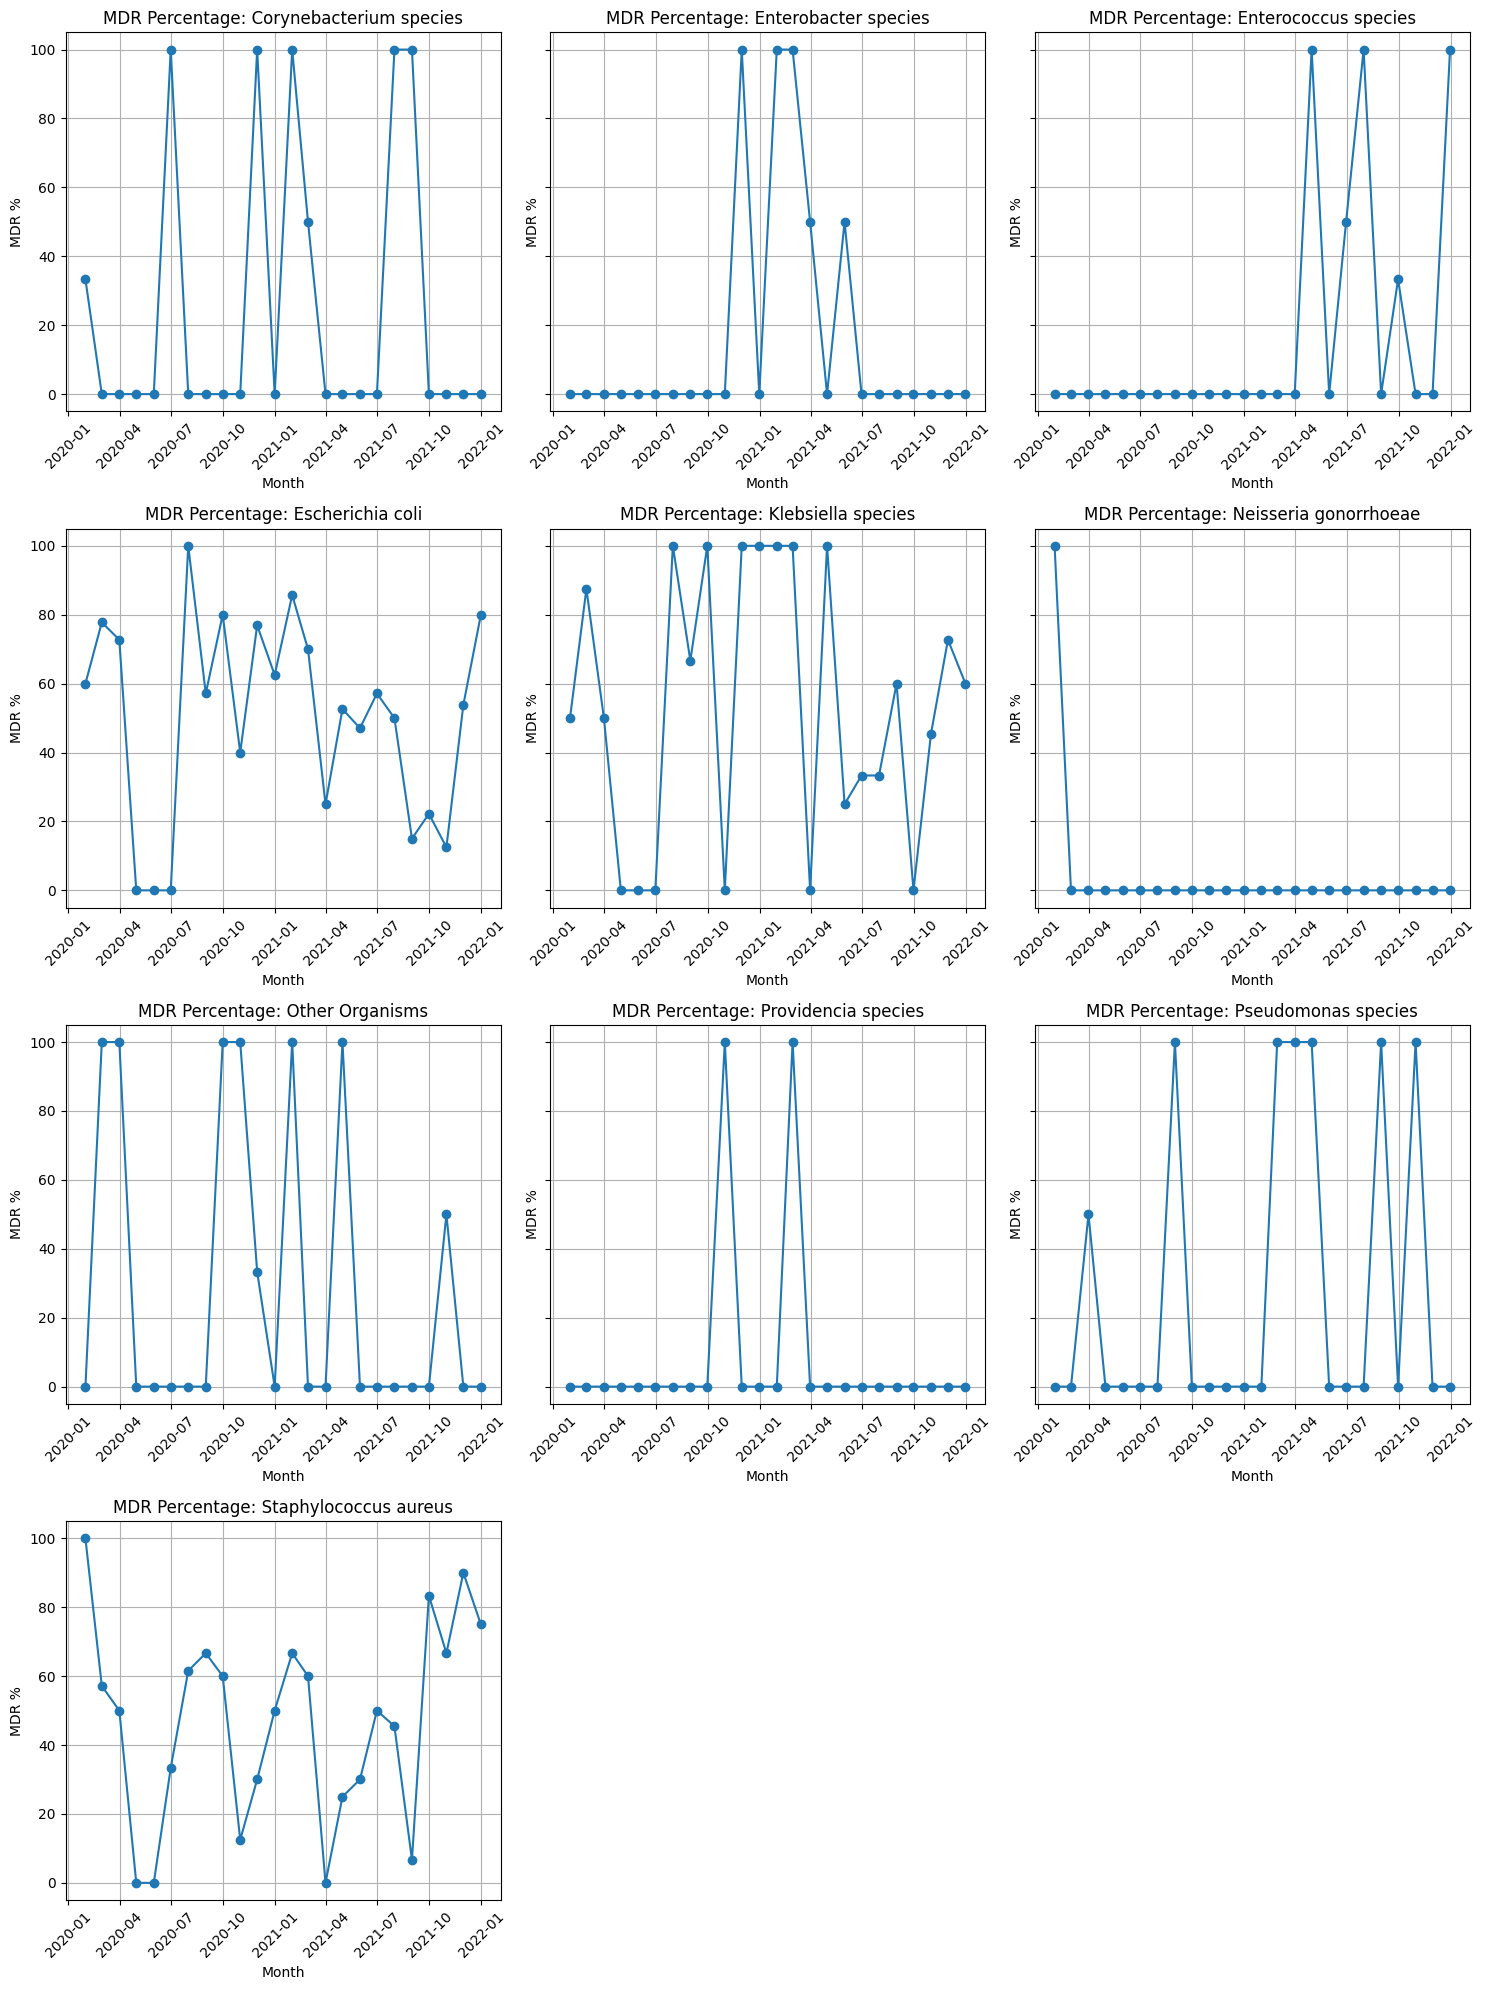

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Ensure 'Specimen date' is in datetime format (using .loc to avoid the SettingWithCopyWarning)
mdr_isolates.loc[:, 'Specimen date'] = pd.to_datetime(mdr_isolates['Specimen date'])

# Filter non-MDR cases
non_mdr_isolates = filtered_data[filtered_data['MDR Status'] == 'Non-MDR']

# Group by 'Specimen date' and 'Organism' to count MDR cases
mdr_time_series = mdr_isolates.groupby([pd.Grouper(key='Specimen date', freq='ME'), 'Organism']).size().unstack(fill_value=0)

# Resample to monthly frequency (month end)
mdr_time_series = mdr_time_series.resample('ME').sum()

# Group by 'Specimen date' and 'Organism' to count non-MDR cases
non_mdr_time_series = non_mdr_isolates.groupby([pd.Grouper(key='Specimen date', freq='ME'), 'Organism']).size().unstack(fill_value=0)

# Resample to monthly frequency (month end)
non_mdr_time_series = non_mdr_time_series.resample('ME').sum()

# Calculate total cases (MDR + Non-MDR) per month per organism
total_time_series = filtered_data.groupby([pd.Grouper(key='Specimen date', freq='ME'), 'Organism']).size().unstack(fill_value=0)
total_time_series = total_time_series.resample('ME').sum()

# Calculate MDR percentage per month using the formula:
mdr_percentage = (mdr_time_series / (mdr_time_series + non_mdr_time_series)) * 100

# Fill missing values with 0 to ensure lines are connected (no NaNs)
mdr_percentage = mdr_percentage.fillna(0)

# Set the number of plots per row (e.g., 3 plots per row)
z = 3  # Change this number to control how many plots per row

# Calculate the number of rows needed based on the number of organisms
num_organisms = len(mdr_percentage.columns)
num_rows = int(np.ceil(num_organisms / z))  # Round up to the nearest integer

# Create the subplot grid with z plots per row
fig, axes = plt.subplots(num_rows, z, figsize=(5 * z, 5 * num_rows), sharey=True)

# Flatten axes array in case we have more than one row
axes = axes.flatten()

# Plot each organism
for idx, organism in enumerate(mdr_percentage.columns):
    ax = axes[idx]
    ax.plot(mdr_percentage.index, mdr_percentage[organism], marker='o', linestyle='-')
    ax.set_title(f'MDR Percentage: {organism}')
    ax.set_xlabel("Month")
    ax.set_ylabel("MDR %")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True)

# Hide any extra empty subplots if there are fewer organisms than grid spaces
for idx in range(num_organisms, len(axes)):
    axes[idx].axis('off')  # Hide the axis for extra subplots

plt.tight_layout()
plt.show()


In [ ]:
mdr_percentage_table = mdr_percentage.reset_index()


In [ ]:
print(mdr_percentage_table)


Organism Specimen date  Corynebacterium species  Enterobacter species  \
0           2020-01-31                33.333333                   0.0   
1           2020-02-29                 0.000000                   0.0   
2           2020-03-31                 0.000000                   0.0   
3           2020-04-30                 0.000000                   0.0   
4           2020-05-31                 0.000000                   0.0   
5           2020-06-30               100.000000                   0.0   
6           2020-07-31                 0.000000                   0.0   
7           2020-08-31                 0.000000                   0.0   
8           2020-09-30                 0.000000                   0.0   
9           2020-10-31                 0.000000                   0.0   
10          2020-11-30               100.000000                 100.0   
11          2020-12-31                 0.000000                   0.0   
12          2021-01-31               100.000000    

In [ ]:
import pandas as pd
from IPython.display import display  # Import display function
from google.colab import data_table

data_table.enable_dataframe_formatter()
data_table.enable_dataframe_formatter()

# ... (your existing code to load and preprocess urine_data) ...

# Get unique organisms and antimicrobial agents
unique_organisms = filtered_data['Organism'].unique()
antibiotic_columns = filtered_data.columns[filtered_data.columns.str.endswith(('_I', '_R', '_S'))]
antimicrobial_agents = list(set([col[:-2] for col in antibiotic_columns]))

# Create a dictionary to store the table data
table_data = {'Bacterial Isolates': [], 'R0 No (%)': [], 'R1 No (%)': [], 'R2 No (%)': [],
              'R3 No (%)': [], 'R4 No (%)': [], 'R5 No (%)': [], 'R6 No (%)': [], '>R7 No (%)': []}

# Iterate through unique organisms
for organism in unique_organisms:
    # Get organism count, handling potential KeyError
    organism_count = filtered_data['Organism'].value_counts().get(organism, 0)

    table_data['Bacterial Isolates'].append(f"{organism} ({organism_count})")

    # Calculate resistance counts for each category directly
    resistance_counts = [0] * 8  # Initialize counts for R0 to >R7

    for i in range(len(resistance_counts)):
        # Calculate count for current resistance level (R0 to >R7)
        count = 0
        for _, row in urine_data[urine_data['Organism'] == organism].iterrows():
            resistance_level = 0
            for agent in antimicrobial_agents:
                if agent + '_I' in row and agent + '_R' in row:
                    if row[agent + '_I'] == 1 or row[agent + '_R'] == 1:
                        resistance_level += 1

            if resistance_level == i:  # Check if resistance level matches current category
                count += 1
            elif resistance_level > 6 and i == 7: # For >R7 category
                count += 1

        resistance_counts[i] = count

    # Calculate percentages and format for the table
    total_isolates = filtered_data['Organism'].value_counts().get(organism, 0)  # Handle KeyError
    for i in range(len(resistance_counts)):
        percentage = (resistance_counts[i] / total_isolates) * 100 if total_isolates else 0
        table_data[f"R{i} No (%)" if i <= 6 else ">R7 No (%)"].append(f"{resistance_counts[i]} ({percentage:.1f}%)")

# Create the DataFrame
multi_drug_resistance_table = pd.DataFrame(table_data)

# Display the table using data_table formatter
display(multi_drug_resistance_table)

,Bacterial Isolates,R0 No (%),R1 No (%),R2 No (%),R3 No (%),R4 No (%),R5 No (%),R6 No (%),>R7 No (%)
0,Escherichia coli (191),3 (1.6%),23 (12.0%),42 (22.0%),50 (26.2%),45 (23.6%),18 (9.4%),4 (2.1%),6 (3.1%)
1,Staphylococcus aureus (182),9 (4.9%),25 (13.7%),36 (19.8%),37 (20.3%),31 (17.0%),20 (11.0%),11 (6.0%),13 (7.1%)
2,Klebsiella species (87),3 (3.4%),1 (1.1%),20 (23.0%),22 (25.3%),18 (20.7%),8 (9.2%),8 (9.2%),7 (8.0%)
3,Enterococcus species (20),0 (0.0%),4 (20.0%),5 (25.0%),5 (25.0%),5 (25.0%),1 (5.0%),0 (0.0%),0 (0.0%)
4,Other Organisms (15),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
5,Pseudomonas species (18),2 (11.1%),2 (11.1%),2 (11.1%),4 (22.2%),3 (16.7%),2 (11.1%),1 (5.6%),2 (11.1%)
6,Corynebacterium species (12),0 (0.0%),1 (8.3%),2 (16.7%),4 (33.3%),3 (25.0%),1 (8.3%),0 (0.0%),1 (8.3%)
7,Enterobacter species (8),0 (0.0%),1 (12.5%),2 (25.0%),1 (12.5%),1 (12.5%),2 (25.0%),1 (12.5%),0 (0.0%)
8,Neisseria gonorrhoeae (11),4 (36.4%),2 (18.2%),4 (36.4%),0 (0.0%),0 (0.0%),0 (0.0%),1 (9.1%),0 (0.0%)
9,Providencia species (6),0 (0.0%),0 (0.0%),1 (16.7%),4 (66.7%),0 (0.0%),1 (16.7%),0 (0.0%),0 (0.0%)


In [ ]:
from datetime import date
print(filtered_data['Specimen date'])



209    2021-12-31
236    2021-12-20
244    2021-12-17
261    2021-12-15
276    2021-12-14
          ...    
4417   2020-01-13
4427   2020-01-09
4436   2020-01-09
4438   2020-01-09
4454   2020-01-06
Name: Specimen date, Length: 550, dtype: datetime64[ns]


In [ ]:
# Ensure 'Specimen date' column is in datetime format
filtered_data['Specimen date'] = pd.to_datetime(filtered_data['Specimen date'], errors='coerce')

# Now, extract the year from the 'Specimen date' column
filtered_data['Year'] = filtered_data['Specimen date'].dt.year

# Check the first few rows to ensure the conversion worked
print(filtered_data[['Specimen date', 'Year']].head())


    Specimen date  Year
209    2021-12-31  2021
236    2021-12-20  2021
244    2021-12-17  2021
261    2021-12-15  2021
276    2021-12-14  2021


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from google.colab import data_table

# Enable DataFrame formatter for Google Colab (optional)
data_table.enable_dataframe_formatter()

# Assuming `urine_data` is preloaded with the appropriate data.

# 1. Ensure 'Specimen date' is in datetime format and extract the year
urine_data['Specimen date'] = pd.to_datetime(urine_data['Specimen date'], errors='coerce')
urine_data['Year'] = urine_data['Specimen date'].dt.year

# 2. Get unique organisms and antimicrobial agents
unique_organisms = urine_data['Organism'].unique()
antibiotic_columns = urine_data.columns[urine_data.columns.str.endswith(('_I', '_R', '_S'))]
antimicrobial_agents = list(set([col[:-2] for col in antibiotic_columns]))

# 3. Initialize a dictionary to store results for antibiotic resistance analysis
results = {}

# 4. Iterate through organisms, antibiotics, and years to calculate resistance patterns
for organism in unique_organisms:
    results[organism] = {}

    for agent in antimicrobial_agents:
        results[organism][agent] = {'years': [], 'resistance_percentages': [], 'resistance_counts': [], 'total_counts': []}

        for year in urine_data['Year'].unique():
            year_data = urine_data[(urine_data['Year'] == year) & (urine_data['Organism'] == organism)]

            # Calculate individual antibiotic resistance counts for R, I, and S
            resistant_count = year_data[f'{agent}_R'].sum() if f'{agent}_R' in year_data else 0
            intermediate_count = year_data[f'{agent}_I'].sum() if f'{agent}_I' in year_data else 0
            susceptible_count = year_data[f'{agent}_S'].sum() if f'{agent}_S' in year_data else 0
            total_count = year_data.shape[0]  # Total isolates for this organism in this year

            # Calculate resistance proportion: (R+I) / (R+I+S) * 100
            resistance_percentage = (resistant_count + intermediate_count) / (resistant_count + intermediate_count + susceptible_count) * 100 if total_count > 0 else 0

            results[organism][agent]['years'].append(year)
            results[organism][agent]['resistance_percentages'].append(resistance_percentage)
            results[organism][agent]['resistance_counts'].append((resistant_count, intermediate_count))
            results[organism][agent]['total_counts'].append(total_count)

# 5. Perform Chi-square test and store p-values
for organism, agent_data in results.items():
    for agent, data in agent_data.items():
        if len(data['years']) > 1:  # Check if data exists for more than one year
            # Create contingency table (adjusting for zero values)
            contingency_table = [
                [data['resistance_counts'][i][0] + data['resistance_counts'][i][1],
                 total - (data['resistance_counts'][i][0] + data['resistance_counts'][i][1])]  # (R + I, S)
                for i, total in enumerate(data['total_counts'])
            ]
            contingency_table = [[max(val, 0.5) for val in row] for row in contingency_table]

            # Perform Chi-square test
            chi2, p_value, _, _ = chi2_contingency(contingency_table)
            results[organism][agent]['p_value'] = p_value

# 6. Create and display the result table (filtering for significant p-values)
resistance_result_table_data = []
for organism, agent_data in results.items():
    for agent, data in agent_data.items():
        p_value = data.get('p_value', None)  # Get p-value, or None if not calculated
        if p_value is not None and p_value < 0.05:  # Check for significance
            resistance_result_table_data.append({
                'Organism': organism,
                'Antibiotic': agent,
                'P-value': f'{p_value:.5f}',
                'Resistance Percentage (2021)': f'{data["resistance_percentages"][-1]:.2f}',  # Last year's value (2021)
                'Resistance Percentage (2020)': f'{data["resistance_percentages"][0]:.2f}',  # First year's value (2020)
            })

resistance_result_table = pd.DataFrame(resistance_result_table_data)
display(resistance_result_table)


<ipython-input-81-8cb4bb270733>:40: RuntimeWarning: invalid value encountered in scalar divide
  resistance_percentage = (resistant_count + intermediate_count) / (resistant_count + intermediate_count + susceptible_count) * 100 if total_count > 0 else 0


,Organism,Antibiotic,P-value,Resistance Percentage (2021),Resistance Percentage (2020)
0,Escherichia coli,Sulfamethoxazole,0.04572,80.36,87.84
1,Escherichia coli,Clindamycin,0.01774,96.36,89.66
2,Escherichia coli,Gentamicin,0.03331,26.00,12.99
3,Escherichia coli,Amoxicillin/Clavulanic Acid,0.00004,71.43,63.16
4,Staphylococcus aureus,Gentamicin,0.00061,37.50,11.32
5,Klebsiella species,Chloramphenicol,0.00156,44.44,16.67
6,Klebsiella species,Clindamycin,0.02767,96.77,72.73
7,Klebsiella species,Cefazolin,0.00156,44.44,16.67
8,Klebsiella species,Gentamicin,0.02137,37.04,20.00
9,Klebsiella species,Amoxicillin/Clavulanic Acid,0.00224,77.78,76.47


In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')


MessageError: Error: credential propagation was unsuccessful

In [ ]:
#export the dataframe to csv
susceptibility_table.to_csv('/content/drive/My Drive/susceptibility_table.csv', index=True)
df_verify = pd.read_csv('/content/drive/My Drive/susceptibility_table.csv')
#print(df_verify)
#export multiple drug resistance table
multi_drug_resistance_table.to_csv('/content/drive/My Drive/multi_drug_resistance_table.csv', index=True)
df_verify = pd.read_csv('/content/drive/My Drive/multi_drug_resistance_table.csv')
#export susceptibility_table
susceptibility_table.to_csv('/content/drive/My Drive/susceptibility_table.csv', index=True)
df_verify = pd.read_csv('/content/drive/My Drive/susceptibility_table.csv')
#print(df_verify)


In [ ]:
#let us do a time series analysis


In [ ]:
# Assuming your DataFrame is named 'df'
all_columns = filtered_data.columns.tolist()

# Print the list with each column name on a new line
for column in all_columns:
    print(column)

Identification number
Specimen number
Organism
Country
Laboratory
Origin
Last name
First name
Sex
Date of Birth
Age
Age category
Location
Institution
Department
Location type
Date of admission
Specimen date
Specimen type
Specimen type (Numeric)
Reason
Isolate number
Organism type
Serotype
Date of data entry
Hospitalised for more than 48hrs at specimen collection time
Patient transferred from another facility?
Prior antibiotic therapy
Amoxicillin
Amoxicillin/Clavulanic Acid
Amikacin
Ampicillin
Azithromycin
Cefepime
Bacitracin
Ceftriaxone
Cefuroxime
Ciprofloxacin
Oxacillin
Chloramphenicol
Cefazolin
Clindamycin
Gentamicin
Gentaheptose
Erythromycin
Tetracycline
Rifampicin
Ampicillin/Sulbactam
Ofloxacin
Sulfamethoxazole
Tobramycin
Optochin
Moxifloxacin
Vancomycin
Penicillin
Nalidixic Acid
Imipenem
Cefaclor
Levofloxacin
Nitrofurantoin
Chlortetracycline
Cefotaxime
Aztreonam
Azlocillin
Cefixime
Cefoxitin 30 mg
Doxycycline
Linezolid
Meropenem
Metronidazole
Piperacillin
Cefovecin
Novobiocin
Cefo